In [322]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter1d
from pandas import DataFrame, Series
import matplotlib.pylab as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import datetime
import pyproj 
import random
import os
import io

%matplotlib inline
np.set_printoptions(precision=3 , suppress= True)

In [421]:
#initial parameters - path
folder_path = '/home/rafaela/internship/time_series/TimeSeries-insar/egm_files'
file_path = os.path.join(folder_path, 'EGMS_L3_E44N25_100km_E.csv')
teste = pd.read_csv(file_path)

teste_reduced = teste.iloc[:,list(range(1, 4)) + list(range(11, 375))]

In [422]:
#define the ETRS89-LAEA and the UTM projection
etrs89_laea = pyproj.CRS("EPSG:3035")
wgs84 = pyproj.CRS("EPSG:4326")
utm_32 = pyproj.CRS("EPSG:23032")

In [423]:
teste_new = teste_reduced.copy()

transformer = pyproj.Transformer.from_crs(etrs89_laea, wgs84)
teste_new["latitude"], teste_new["longitude"] = transformer.transform(teste_new["northing"].to_numpy(), teste_new["easting"].to_numpy())

In [424]:
latitude_min = 45.00
latitude_max = 46.90
longitude_min = 11.00
longitude_max = 12.90

teste_area_selected = teste_new[((teste_new['latitude'] >= latitude_min) & (teste_new['latitude'] <= latitude_max) &
                  (teste_new['longitude'] >= longitude_min) & (teste_new['longitude'] <= longitude_max))]

print(teste_area_selected)

        easting  northing  height  20160105  20160111  20160117  20160123  \
0       4499150   2596450  2186.4       3.2       5.8       3.2       1.6   
1       4499350   2596550  2060.1       8.4       6.5       6.2       4.6   
2       4499150   2596550  2112.4      -1.0      -0.8      -2.5      -3.2   
3       4498950   2596550  2075.7       1.7       0.9       0.3      -1.1   
4       4498850   2596550  2024.0       1.1       1.5       2.7       0.8   
...         ...       ...     ...       ...       ...       ...       ...   
209839  4415850   2516650   565.8      -0.9      -0.2      -0.1      -0.8   
209840  4415950   2516650   563.0      -0.0      -0.4      -0.4      -0.4   
209841  4416050   2516650   551.3      -1.2      -0.6      -0.4       2.4   
209842  4416150   2516650   537.0       2.0      -0.3      -1.1      -2.4   
209843  4416250   2516750   535.2      -1.0       0.2       0.5      -1.1   

        20160129  20160204  20160210  ...  20211110  20211116  20211122  \


In [465]:
file_name = 'trvs'
p_number = 403 
file = pd.read_csv(f'/home/rafaela/internship/time_series/TimeSeries-insar/egm_files/insar_ts_plots/east/points_after_avg_rolling_mean/{file_name}/{p_number}_pixels/{file_name}_east_{p_number}pixels.csv', index_col=0)
print(file.keys())

Index(['12427', '12433', '12435', '12495', '12497', '12498', '12499', '12500',
       '12501', '12502',
       ...
       '14866', '14867', '14868', '14869', '14870', '14871', '14872', '14873',
       '14874', '15221'],
      dtype='object', length=403)


In [466]:
file_columns = pd.to_numeric(file.columns)
file_pixels = teste_area_selected.iloc[:, 3:367]
file_pixels = file_pixels.loc[file_columns, :]
file_pixels = file_pixels.transpose()

file_pixels.index.name = 'Date'
file_pixels.index = pd.to_datetime(file_pixels.index, format='%Y%m%d')
file_pixels_df = pd.DataFrame(file_pixels, index=file_pixels.index)

print(file_pixels)

            12427  12433  12435  12495  12497  12498  12499  12500  12501  \
Date                                                                        
2016-01-05    1.2   -0.1   -0.2    0.6    0.3    1.7   -4.3    0.1   -0.8   
2016-01-11    0.7    0.1   -0.3   -0.4   -1.2    1.2   -4.8    0.1   -1.9   
2016-01-17    0.6   -0.5    0.3   -0.4   -1.7    1.1   -0.9   -0.2   -1.1   
2016-01-23    0.3   -0.8    0.7    0.0   -0.5    1.3    0.8   -0.4   -0.4   
2016-01-29   -1.1   -0.6    0.9   -0.6   -0.2    2.0    1.0    0.1    0.2   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2021-11-28   -2.0   -4.1   -2.9   -5.2   -3.4   -5.3   -3.7   -2.3   -2.0   
2021-12-04   -2.8   -4.1   -2.0   -3.5    1.6   -2.6   -1.8   -2.5   -2.4   
2021-12-10   -3.2   -3.6   -2.9   -3.5   -1.5   -4.6   -4.7   -2.4   -1.8   
2021-12-16   -3.9   -3.9   -2.3   -4.1   -1.7   -2.8   -4.7   -1.6   -2.4   
2021-12-22   -4.4   -4.0   -2.4   -3.9   -0.9   -3.0   -2.2   -1.7   -2.1   

In [467]:
def linear_detrend(column, file_pixels):
 
    #getting the linear model to substract from the original time series:    
    x = np.arange(len(file_pixels)).reshape(-1, 1)
    y = file_pixels[column].values.reshape(-1, 1)
    
    linear_model = LinearRegression().fit(x, y)
    regression_line = linear_model.predict(x)
    
    detrended_values = y.flatten() - regression_line.flatten()
    #detrended_values = station_data[f'{station_name}_east(m)'].values - regression_line.flatten()
    
    detrended_dataframe = pd.DataFrame(
        detrended_values, 
        index=file_pixels.index, 
        columns=[column])
        
    return detrended_dataframe


#dictionaries to store the data
detrended_data_dict = {}

#calling the function
for column in file_pixels.columns:
    
    #column_name = mgrd_pixels_df.columns[0]
    detrended_dataframe = linear_detrend(
        column, 
        file_pixels)
    detrended_data_dict[column] = detrended_dataframe

#printing dataframe
#stations detrended
#for indice_number, indice_data in detrended_data_dict.items():
    #print(f'{indice_number}: \n{indice_data}\n')

In [468]:
def remove_outliers(indice_number, indice_data):
    limiar_z = 4.0
    
    
    selecting_outliers = indice_data[(np.abs(indice_data-indice_data.mean()) 
                                              < limiar_z*indice_data.std())]
    
    
    outliers_removed_dataframe = pd.DataFrame(selecting_outliers, 
                                              index=indice_data.index)
    
    outliers_removed_dataframe = outliers_removed_dataframe.rename(
        columns={f'{indice_number}_east(mm)_detrended':f'{indice_number}_east(mm)'})  
    
    outliers_removed_dataframe.dropna(inplace=True)
    
    return outliers_removed_dataframe

#dictionaries to store the data
area_outliers_removed_dict = {}

#calling the function
for indice_number, indice_data in detrended_data_dict.items():
    outliers_removed_dataframe = remove_outliers(
        indice_number, 
        indice_data)
    area_outliers_removed_dict[indice_number] = outliers_removed_dataframe

#printing dataframe
#stations detrended
for indice_number, indice_data in area_outliers_removed_dict.items():
    print(f'{indice_number}: \n{indice_data}\n')

12427: 
               12427
Date                
2016-01-05  0.607763
2016-01-11  0.116094
2016-01-17  0.024424
2016-01-23 -0.267245
2016-01-29 -1.658914
...              ...
2021-11-28  0.398475
2021-12-04 -0.393195
2021-12-10 -0.784864
2021-12-16 -1.476533
2021-12-22 -1.968203

[364 rows x 1 columns]

12433: 
               12433
Date                
2016-01-05 -0.410534
2016-01-11 -0.199141
2016-01-17 -0.787747
2016-01-23 -1.076353
2016-01-29 -0.864960
...              ...
2021-11-28 -0.320205
2021-12-04 -0.308811
2021-12-10  0.202582
2021-12-16 -0.086024
2021-12-22 -0.174630

[364 rows x 1 columns]

12435: 
               12435
Date                
2016-01-05 -1.476225
2016-01-11 -1.570463
2016-01-17 -0.964701
2016-01-23 -0.558940
2016-01-29 -0.353178
...              ...
2021-11-28 -2.107811
2021-12-04 -1.202049
2021-12-10 -2.096288
2021-12-16 -1.490526
2021-12-22 -1.584764

[364 rows x 1 columns]

12495: 
               12495
Date                
2016-01-05 -0.850361
2016-01-11 

In [469]:
def get_rolling_mean(indice_number, indice_data):
    
    area_rolling_mean = indice_data.rolling(2, min_periods=1).mean()
    
    areas_rolling_mean_dataframe = pd.DataFrame(area_rolling_mean, 
                                              index=indice_data.index)
    
    areas_rolling_mean_dataframe = areas_rolling_mean_dataframe.rename(
        columns={f'{indice_number}_east(mm)':f'{indice_number}_east(mm)_rm'})
    
    areas_rolling_mean_dataframe.dropna(inplace=True)
    
    return areas_rolling_mean_dataframe

#dictionaries to store the data
areas_rolling_mean_dict = {}

#calling the function
for indice_number, indice_data in area_outliers_removed_dict.items():
    areas_rolling_mean_dataframe = get_rolling_mean(indice_number, indice_data)
    areas_rolling_mean_dict[indice_number] = areas_rolling_mean_dataframe

#printing dataframe
#stations detrended
for indice_number, indice_data in areas_rolling_mean_dict.items():
    print(f'{indice_number}: \n{indice_data}\n')

12427: 
               12427
Date                
2016-01-05  0.607763
2016-01-11  0.361928
2016-01-17  0.070259
2016-01-23 -0.121410
2016-01-29 -0.963080
...              ...
2021-11-28 -0.555691
2021-12-04  0.002640
2021-12-10 -0.589029
2021-12-16 -1.130699
2021-12-22 -1.722368

[364 rows x 1 columns]

12433: 
               12433
Date                
2016-01-05 -0.410534
2016-01-11 -0.304838
2016-01-17 -0.493444
2016-01-23 -0.932050
2016-01-29 -0.970657
...              ...
2021-11-28 -0.625902
2021-12-04 -0.314508
2021-12-10 -0.053115
2021-12-16  0.058279
2021-12-22 -0.130327

[364 rows x 1 columns]

12435: 
               12435
Date                
2016-01-05 -1.476225
2016-01-11 -1.523344
2016-01-17 -1.267582
2016-01-23 -0.761821
2016-01-29 -0.456059
...              ...
2021-11-28 -1.910692
2021-12-04 -1.654930
2021-12-10 -1.649168
2021-12-16 -1.793407
2021-12-22 -1.537645

[364 rows x 1 columns]

12495: 
               12495
Date                
2016-01-05 -0.850361
2016-01-11 

In [470]:
rm_df = pd.concat(areas_rolling_mean_dict.values(), axis=1)

folder_path = f'/home/rafaela/internship/time_series/TimeSeries-insar/egm_files/insar_ts_plots/east/points_after_avg_rolling_mean/{file_name}'
#file_path = os.path.join(folder_path, f'{file_name}_east_{len(areas_rolling_mean_dict)}pixels_rm.csv')
file_path = os.path.join(folder_path, f'{file_name}_concentrated_pixels_rm.csv')
rm_df.to_csv(file_path, index=True)

In [471]:
#getting the average - all points 
all_rm_data = pd.DataFrame()

for indice_number, indice_data in areas_rolling_mean_dict.items():
    all_rm_data[indice_number] = indice_data.squeeze()

avg_rm = all_rm_data.mean(axis=1).rolling(2, min_periods=1).mean()
avg_rm_df = pd.DataFrame(avg_rm)
avg_rm_df.columns = ['avg1_east(mm)']

print(avg_rm_df)

            avg1_east(mm)
Date                     
2016-01-05      -0.675066
2016-01-11      -0.726381
2016-01-17      -0.768354
2016-01-23      -0.652088
2016-01-29      -0.538676
...                   ...
2021-11-28      -0.940542
2021-12-04      -0.972544
2021-12-10      -0.926828
2021-12-16      -0.895668
2021-12-22      -0.853596

[364 rows x 1 columns]


/tmp/ipykernel_4587/3680429869.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_rm_data[indice_number] = indice_data.squeeze()


In [472]:
folder_path = f'/home/rafaela/internship/time_series/TimeSeries-insar/egm_files/insar_ts_plots/east/points_after_avg_rolling_mean/{file_name}'
file_path = os.path.join(folder_path, f'{file_name}_concentraded_avg.csv')
avg_rm_df.to_csv(file_path, index=True)

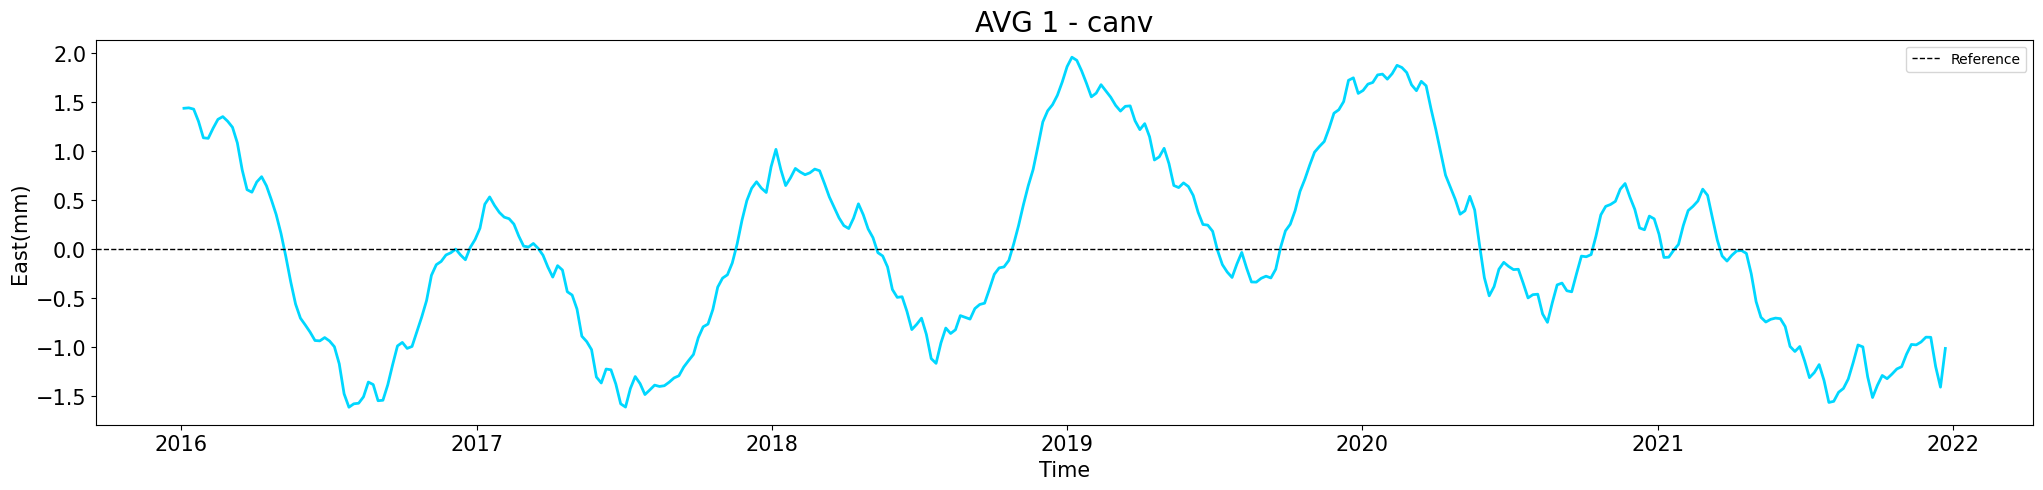

In [321]:
folder = f'/home/rafaela/internship/time_series/TimeSeries-insar/egm_files/insar_ts_plots/east/points_after_avg_rolling_mean/{file_name}'

plt.figure(figsize=(25, 5))
plt.plot(avg_rm_df.index, avg_rm_df, color=color, lw=2) 
plt.title(f'AVG 1 - {file_name}', fontsize = 20)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Reference')
plt.xlabel('Time', fontsize = 15)
plt.xticks(fontsize=15)
plt.ylabel('East(mm)', fontsize = 15)                                       
plt.yticks(fontsize=15)
#plt.ylim(-0.008,0.008)

plt.legend()
    
fl = os.path.join(folder, f'AVG1 - {file_name}.svg')
f = io.BytesIO()
#plt.savefig(fl, format="svg")
    
plt.show()

In [316]:
#removing the avg1 from the time series
points_avgrm_reduced = pd.DataFrame()

for indice_number, indice_data in areas_rolling_mean_dict.items():
    points_avgrm_reduced[indice_number] = indice_data[indice_number] - avg_rm
        
print(points_avgrm_reduced)

              185885    141802    185285    184797    164210    164784  \
Date                                                                     
2016-01-05  1.740102 -0.944019 -1.604091 -1.171041 -0.931970  1.452856   
2016-01-11  1.394584 -1.090737 -1.505035 -2.020076 -0.981299  1.454470   
2016-01-17  1.125379 -1.412344 -1.335093 -2.296314 -0.858126  1.229530   
2016-01-23  1.668345 -1.321779 -1.452979 -1.060380 -0.172781  0.916761   
2016-01-29  2.002790 -0.589737 -1.579388 -0.182969  0.354041  0.795469   
...              ...       ...       ...       ...       ...       ...   
2021-11-28  2.575349 -1.969833  1.390358 -7.307135 -0.929269  0.781812   
2021-12-04  2.944452 -1.403131  0.598608 -2.795064 -0.867788  0.595179   
2021-12-10  3.559578 -2.190407  0.802881 -2.736972 -0.910284  0.554569   
2021-12-16  4.087910 -2.514477  0.270360 -2.315672 -0.539574  0.927166   
2021-12-22  3.710705 -2.044084 -0.367698 -1.199911 -1.024402  1.094225   

              185474    165959    184

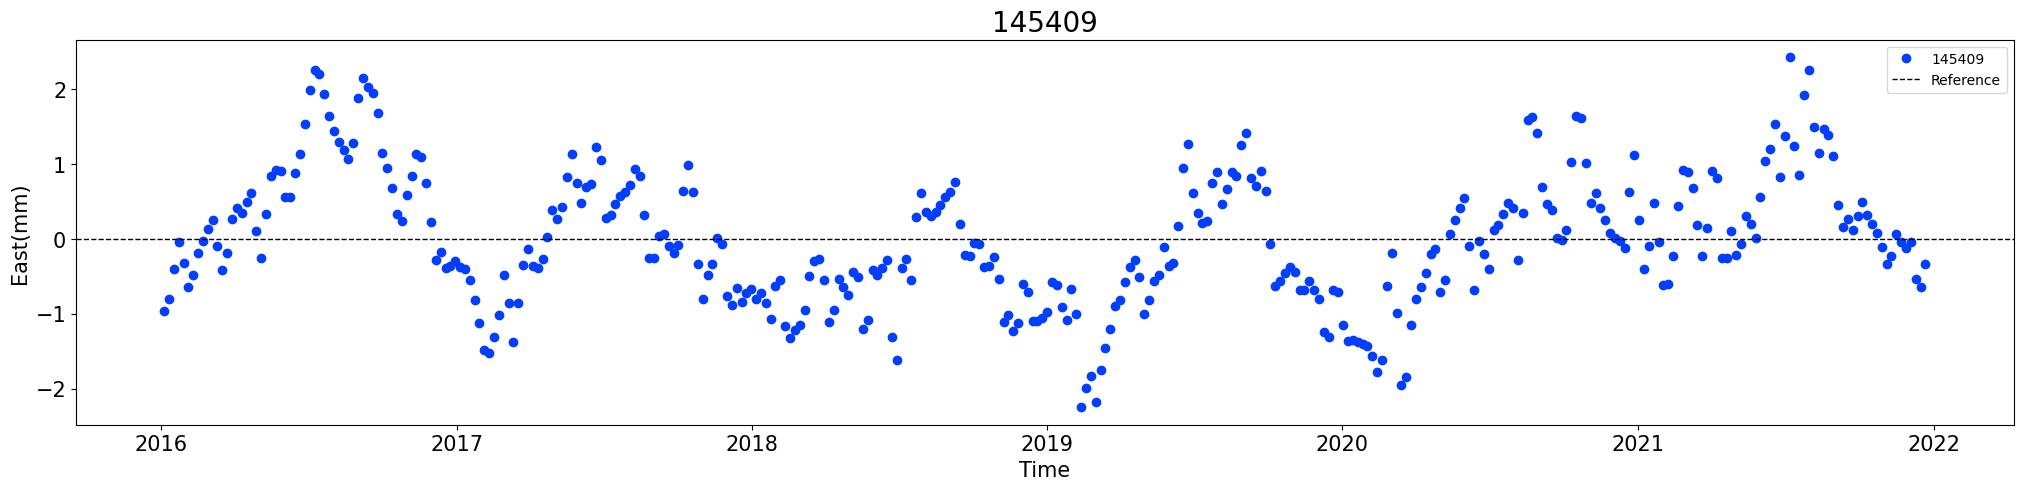

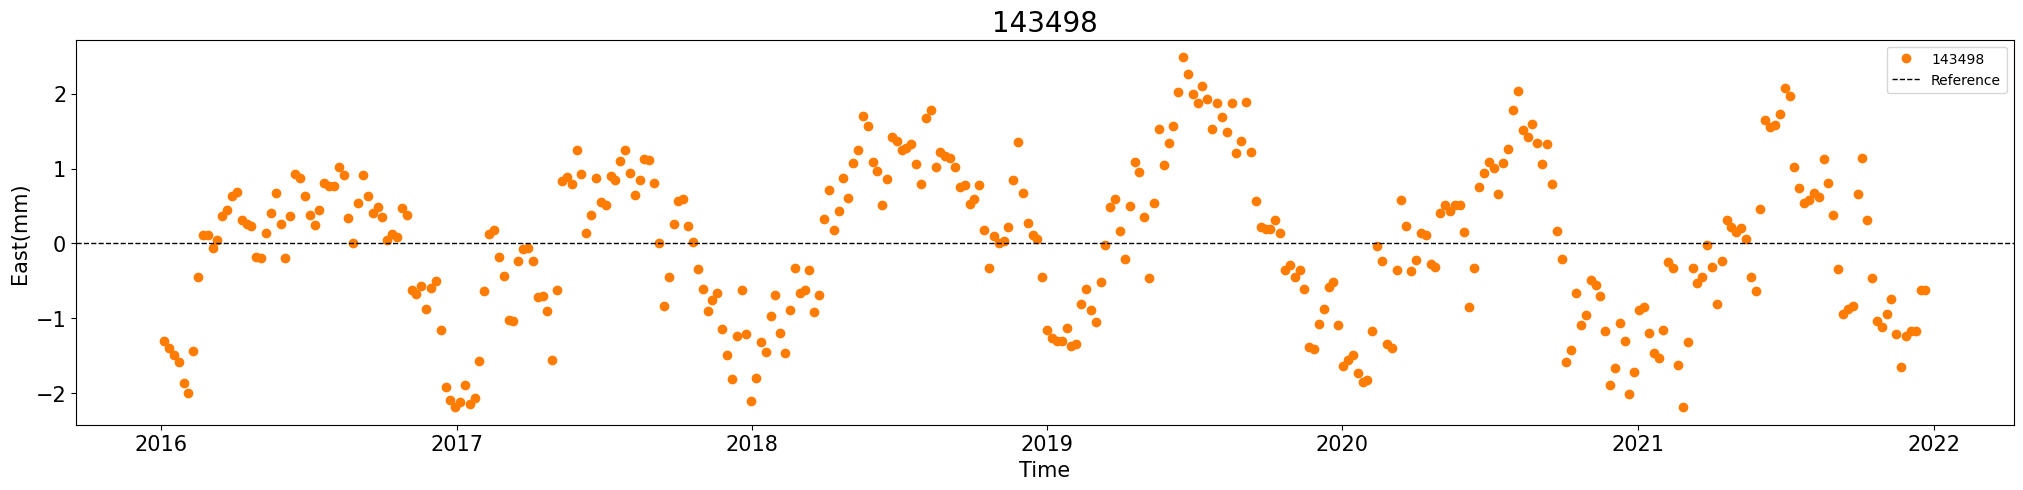

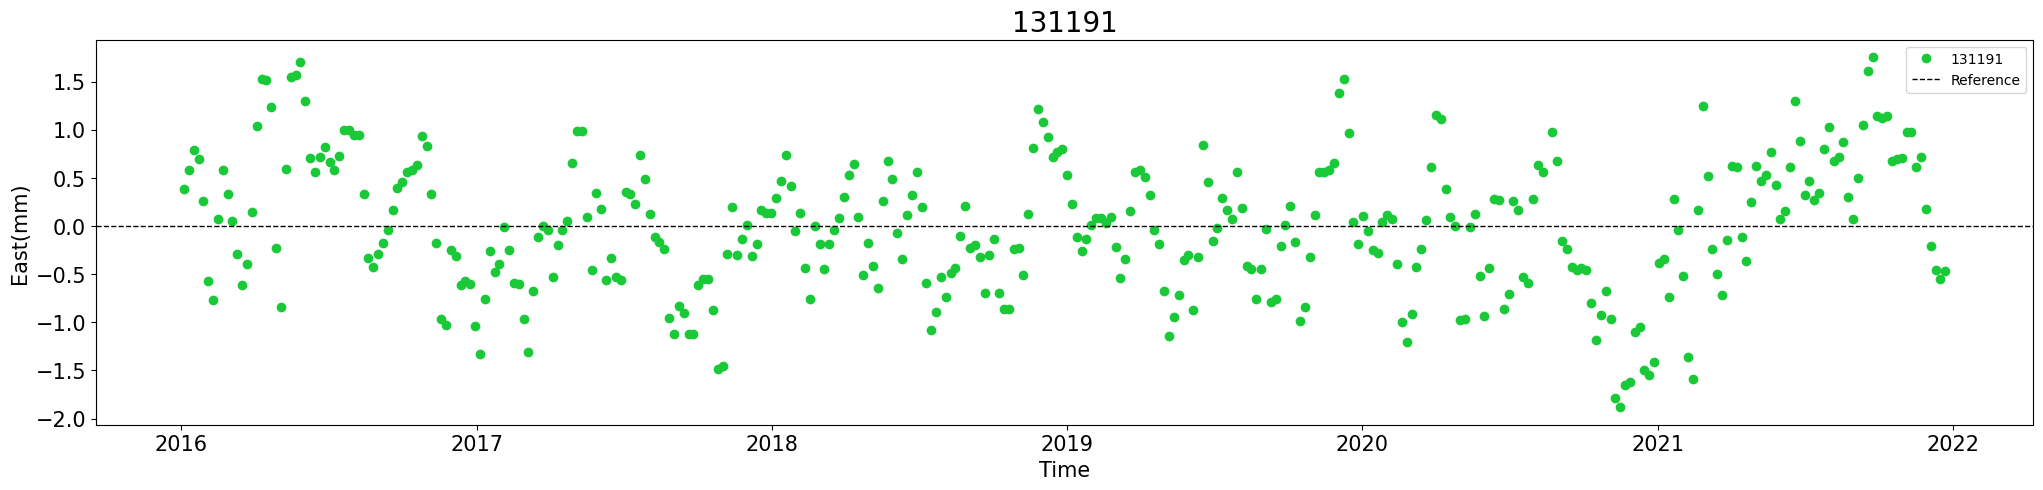

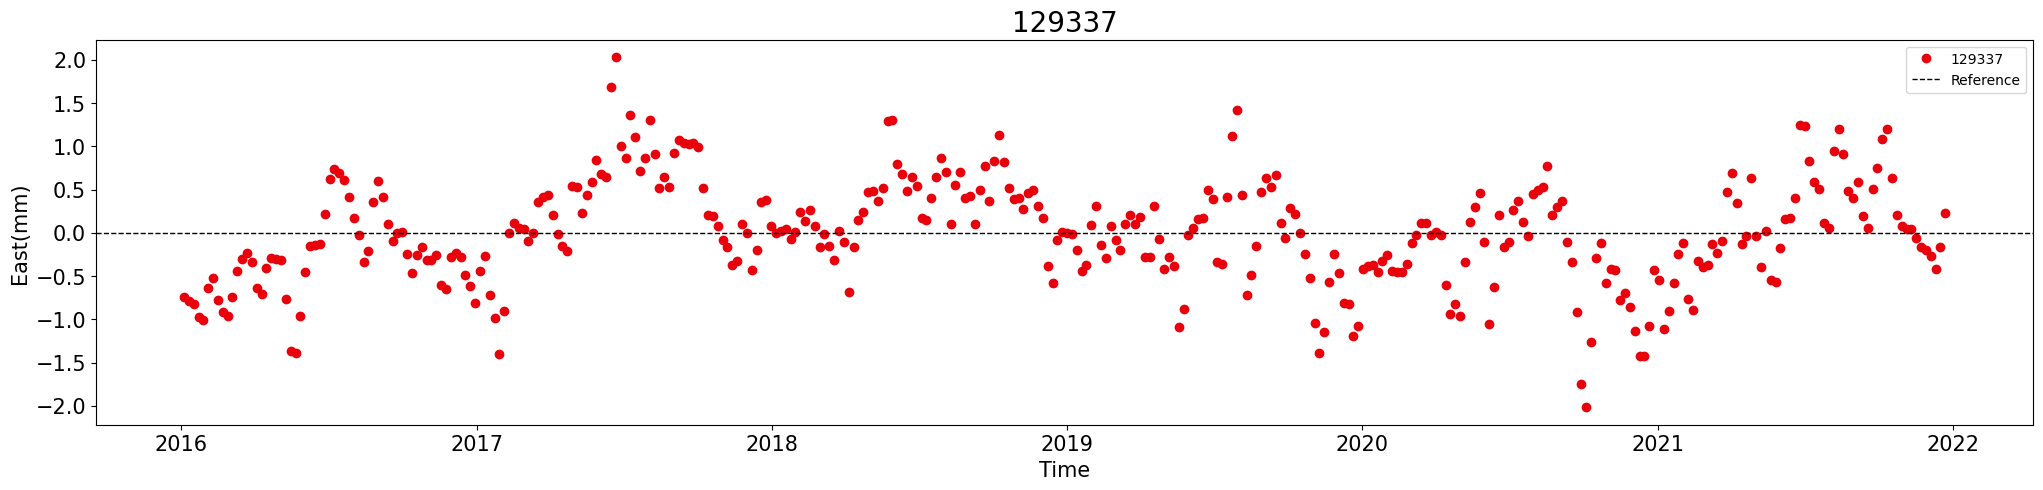

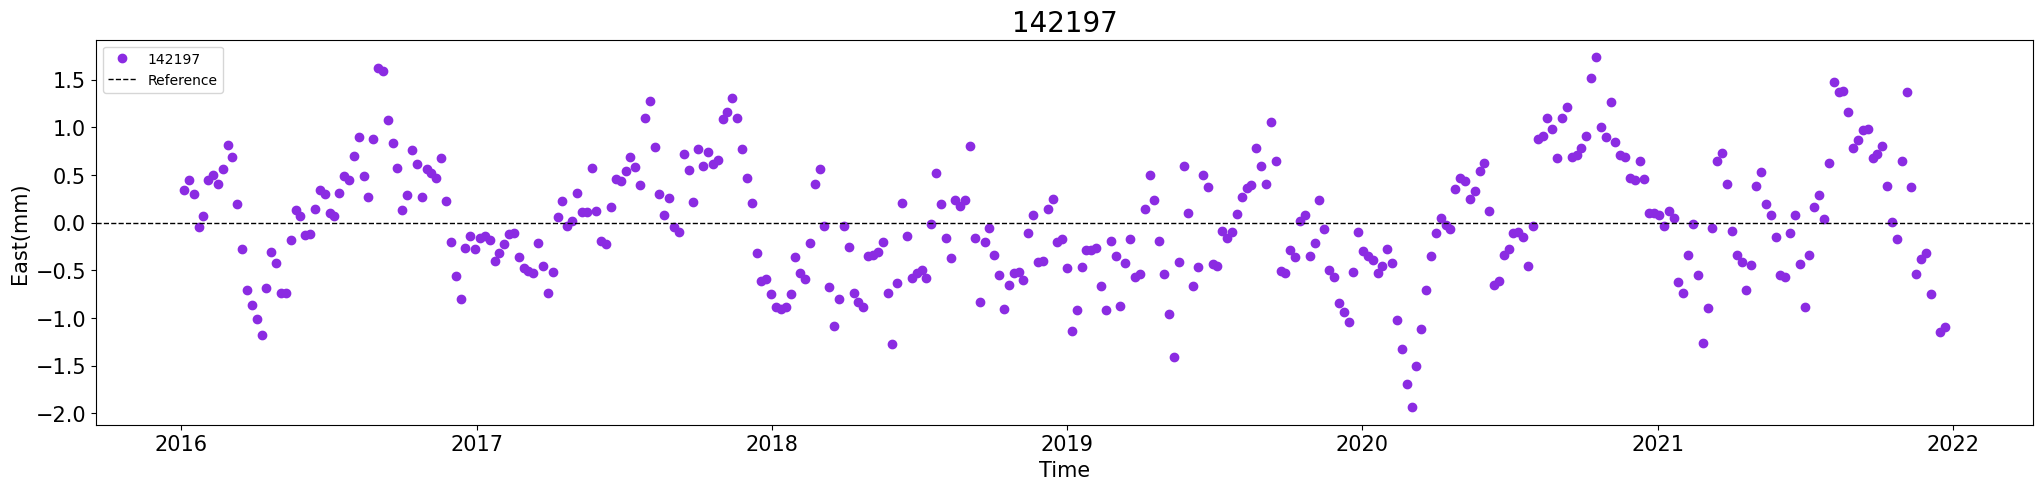

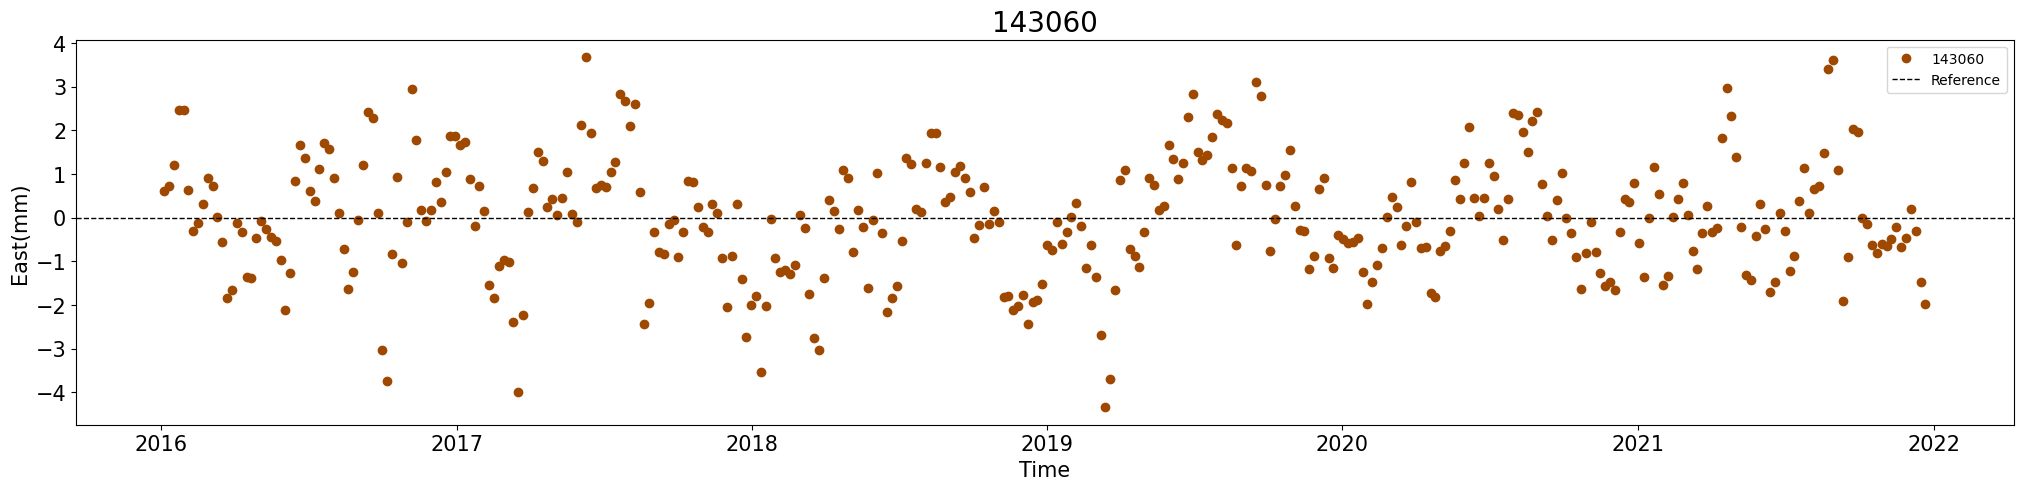

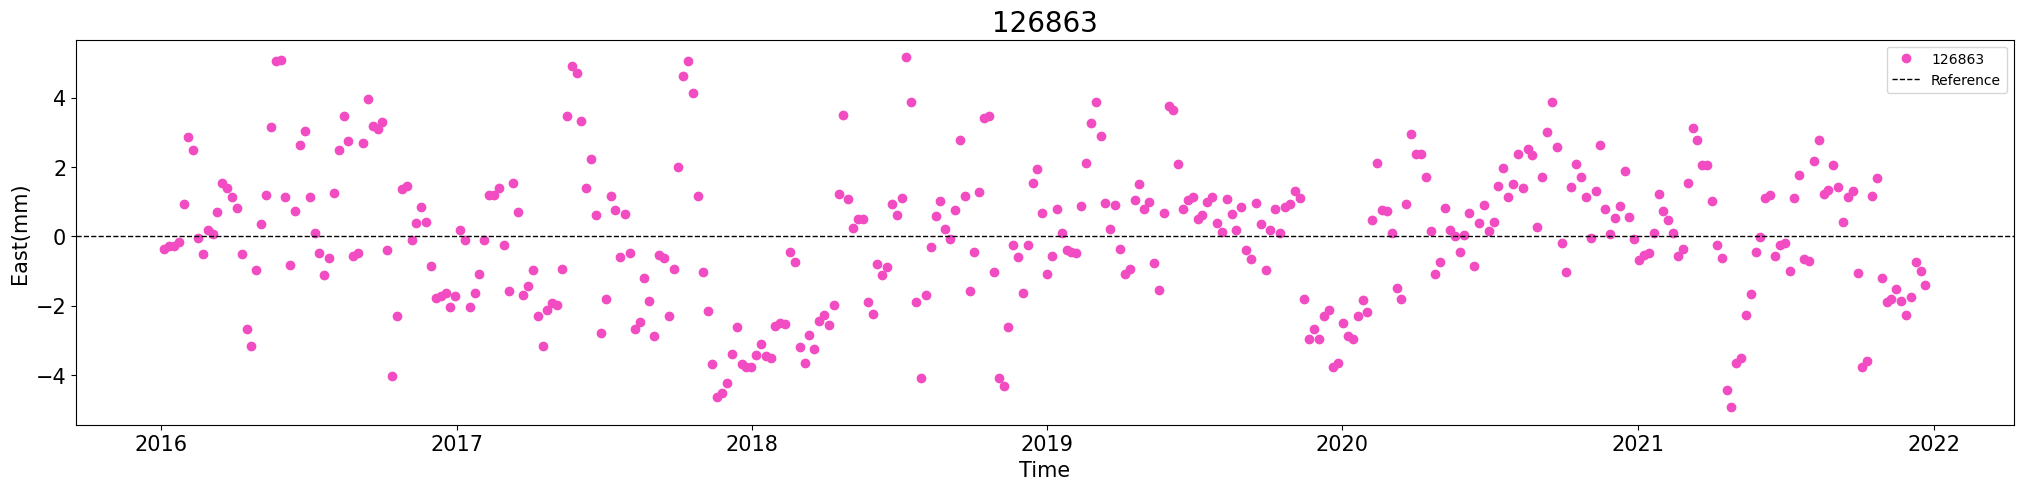

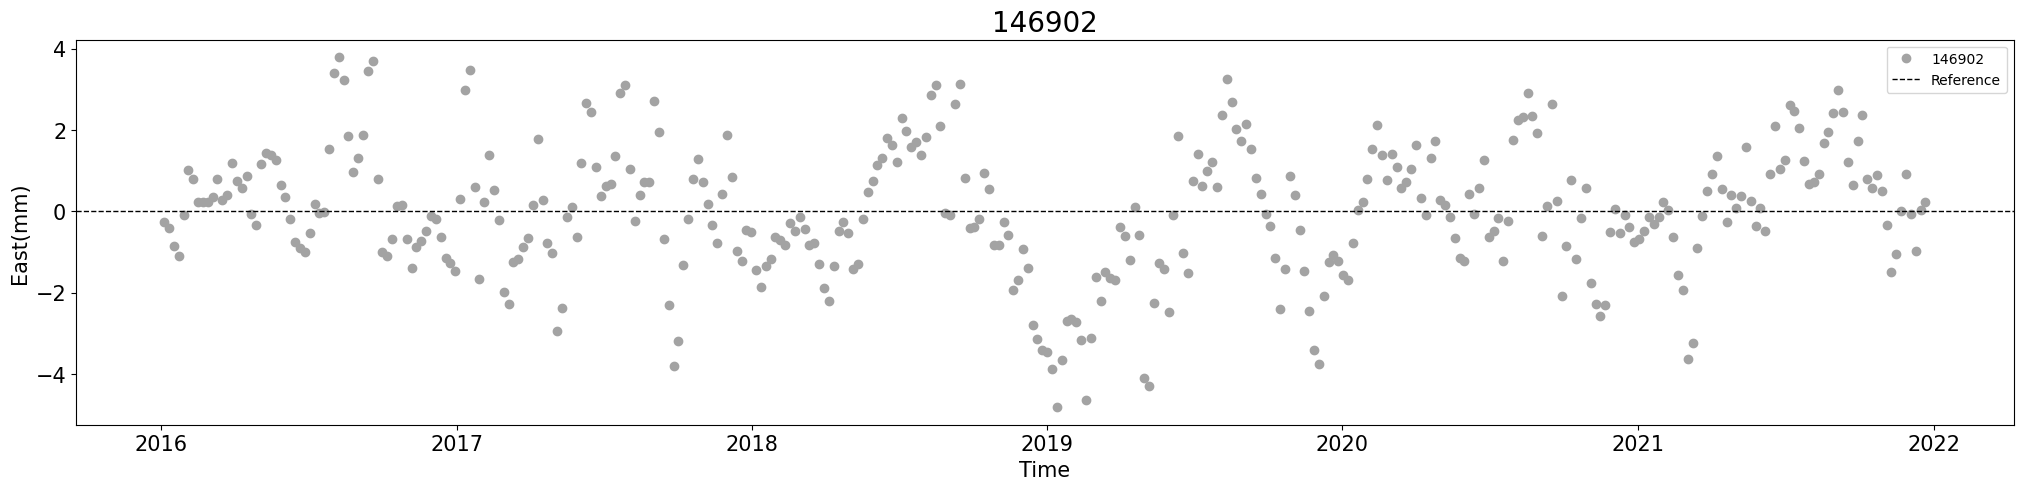

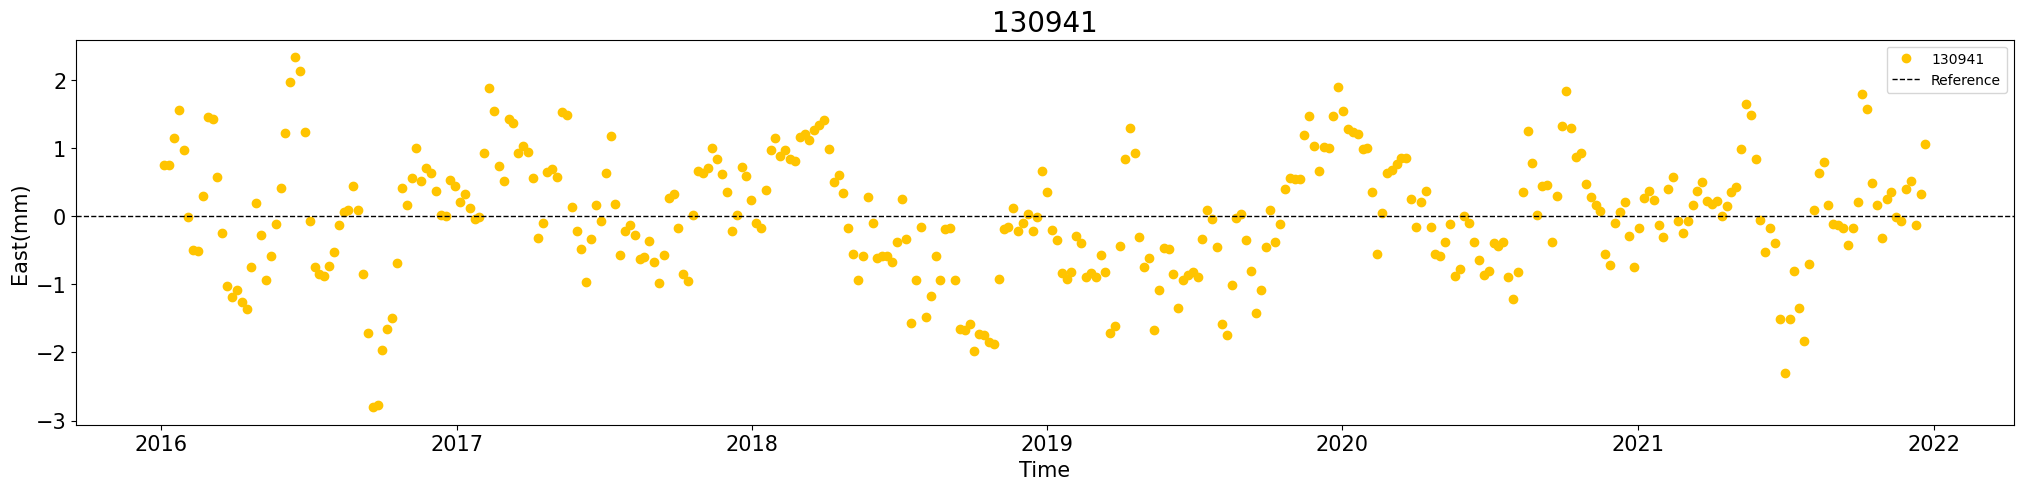

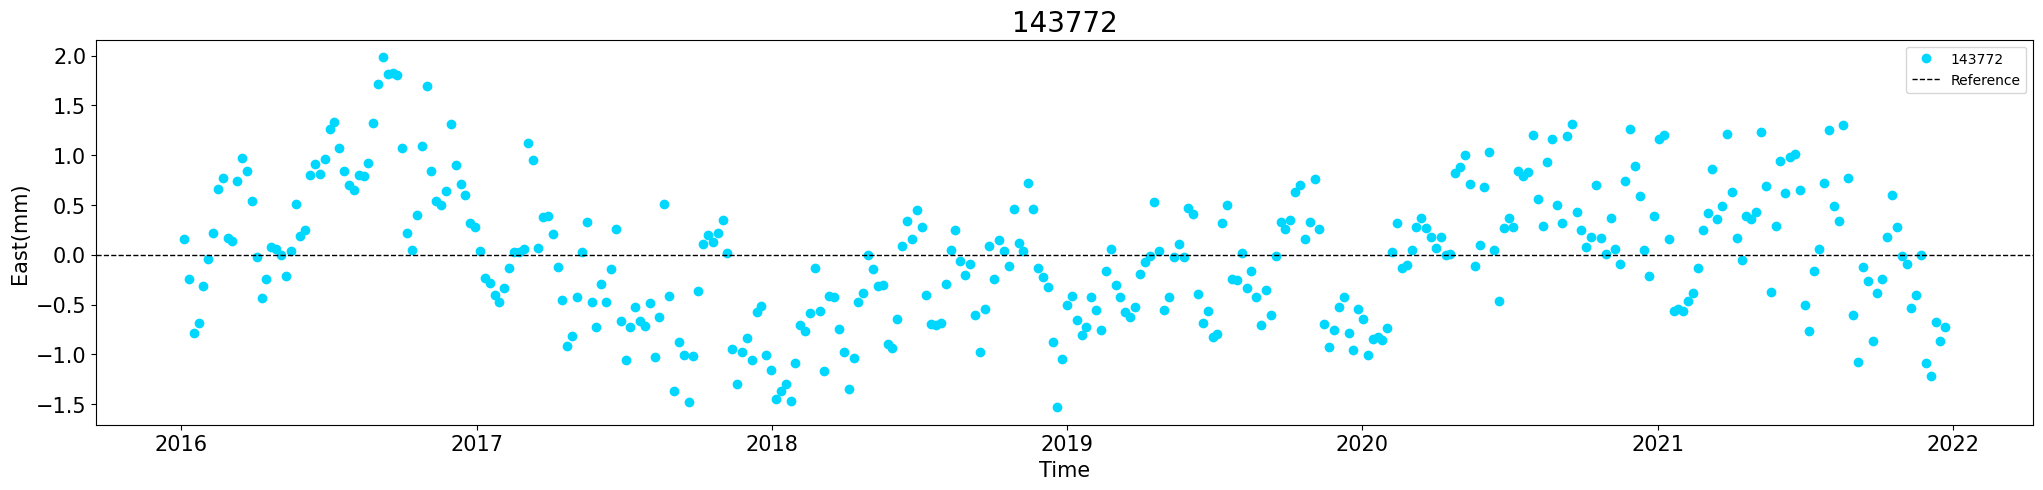

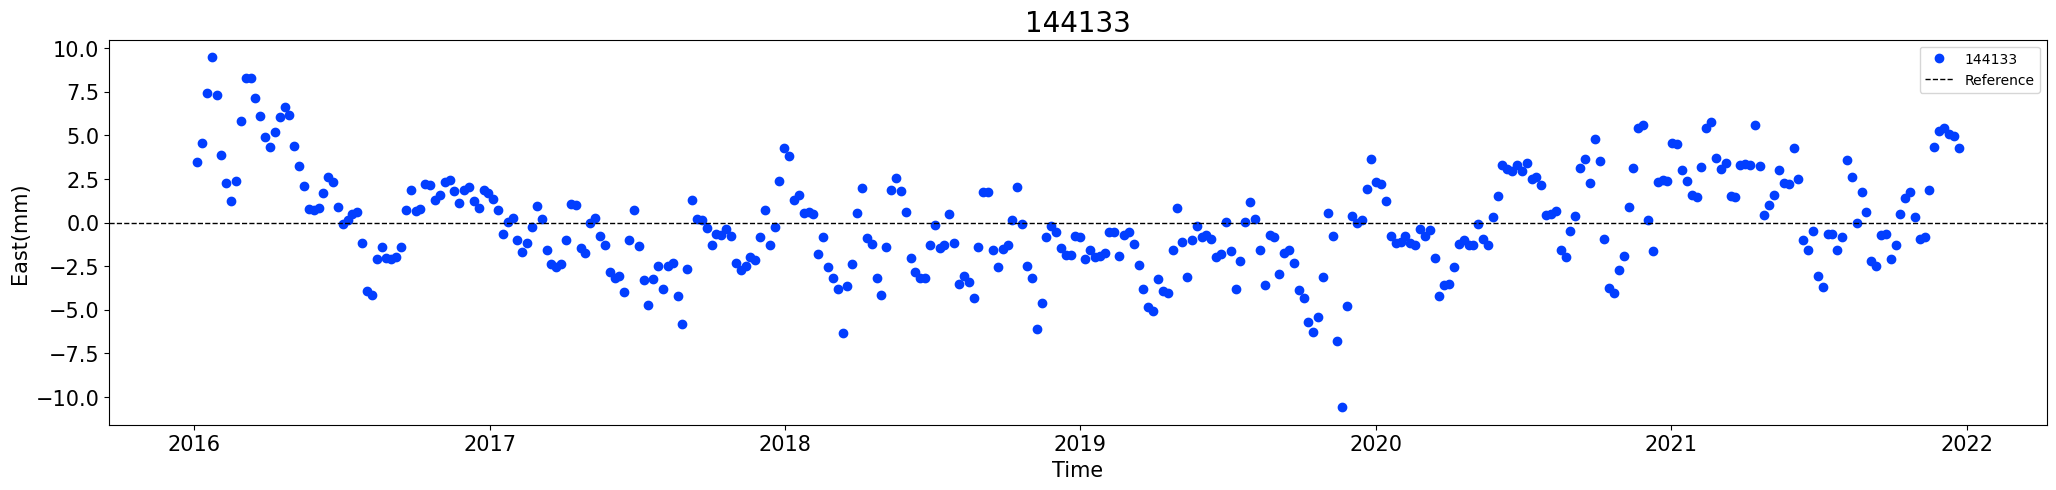

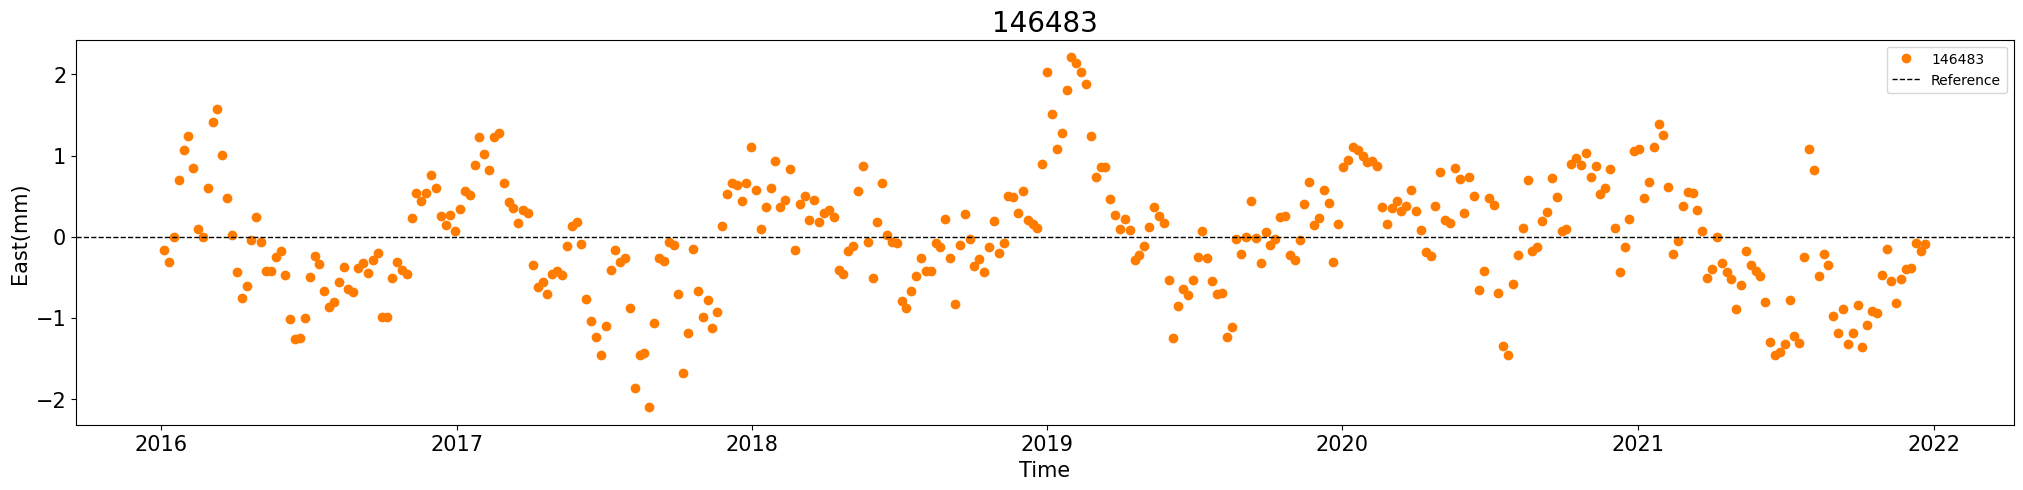

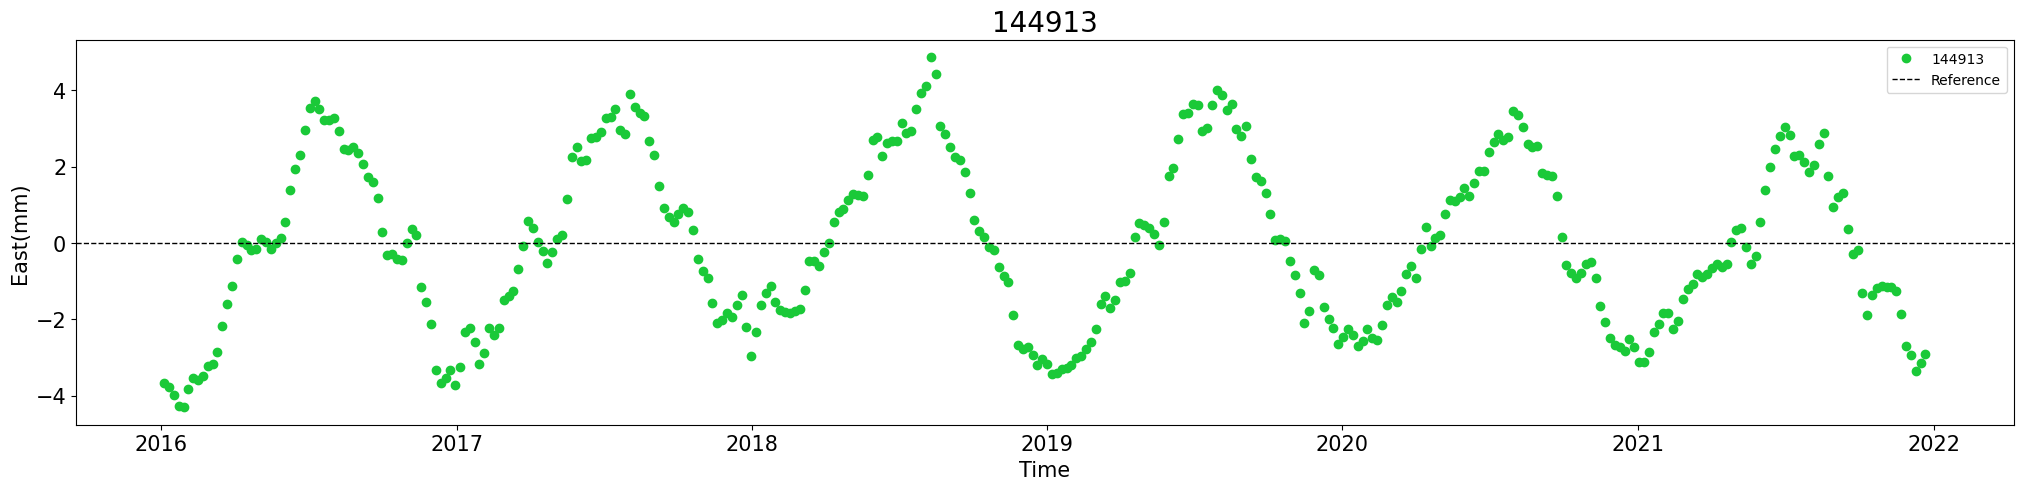

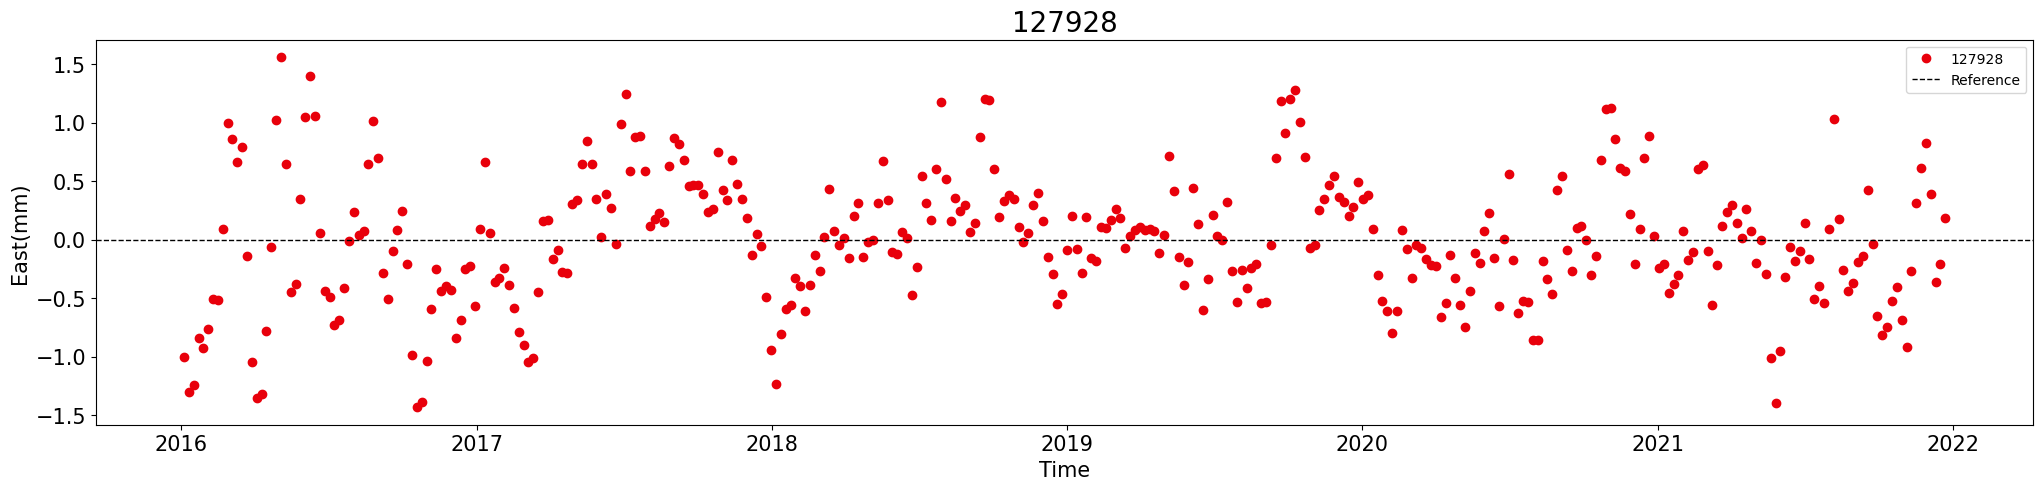

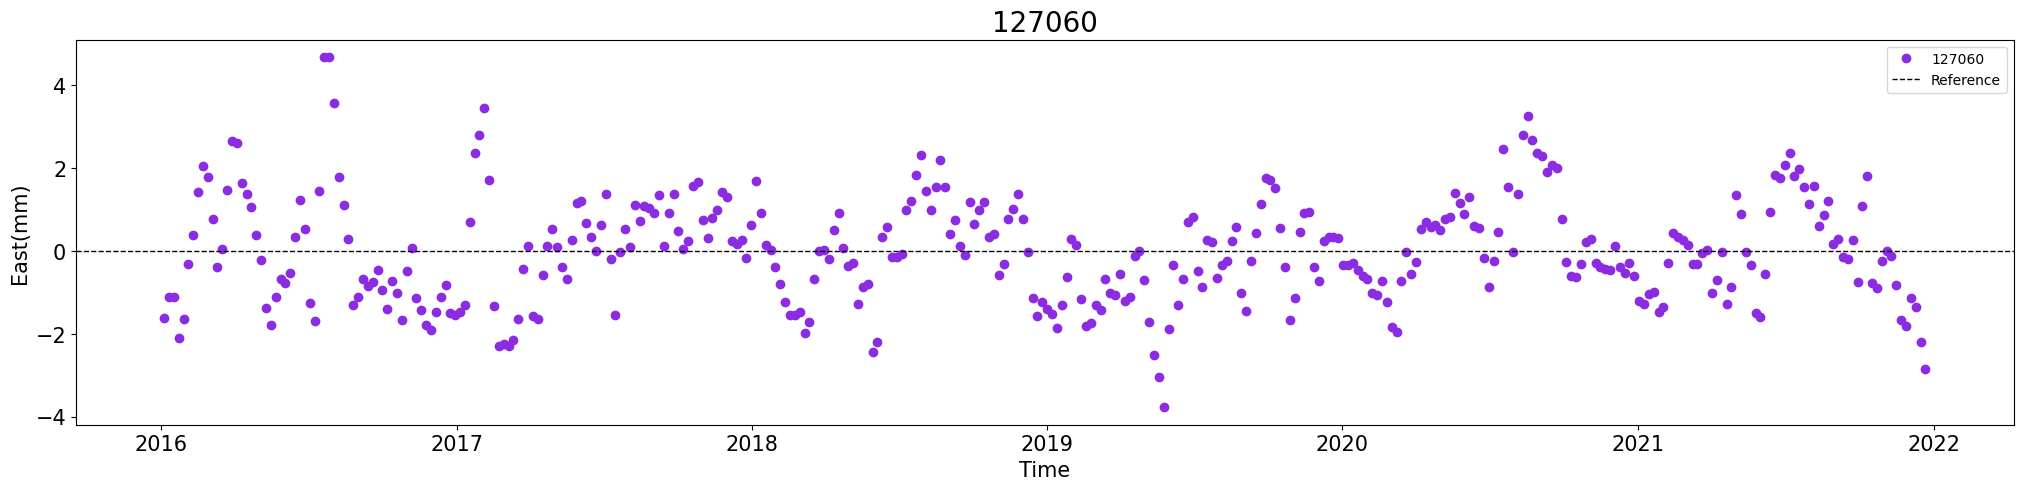

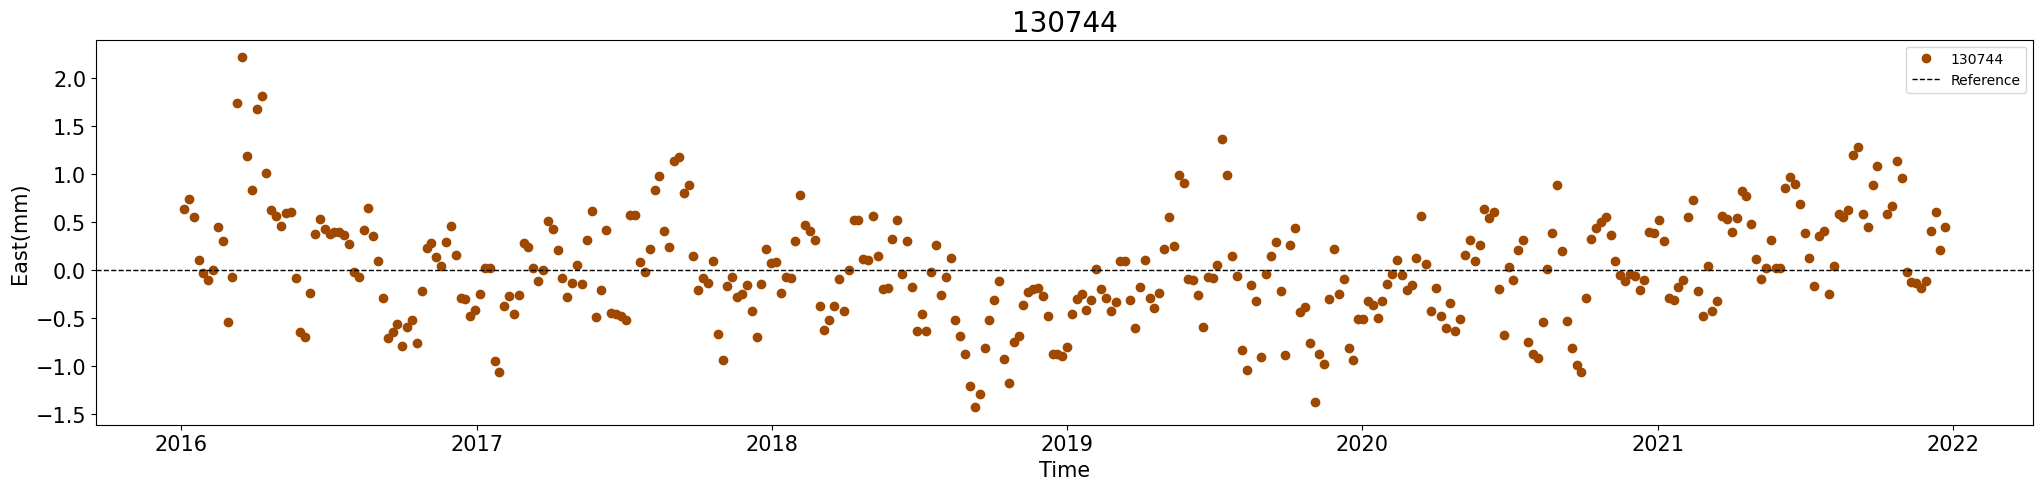

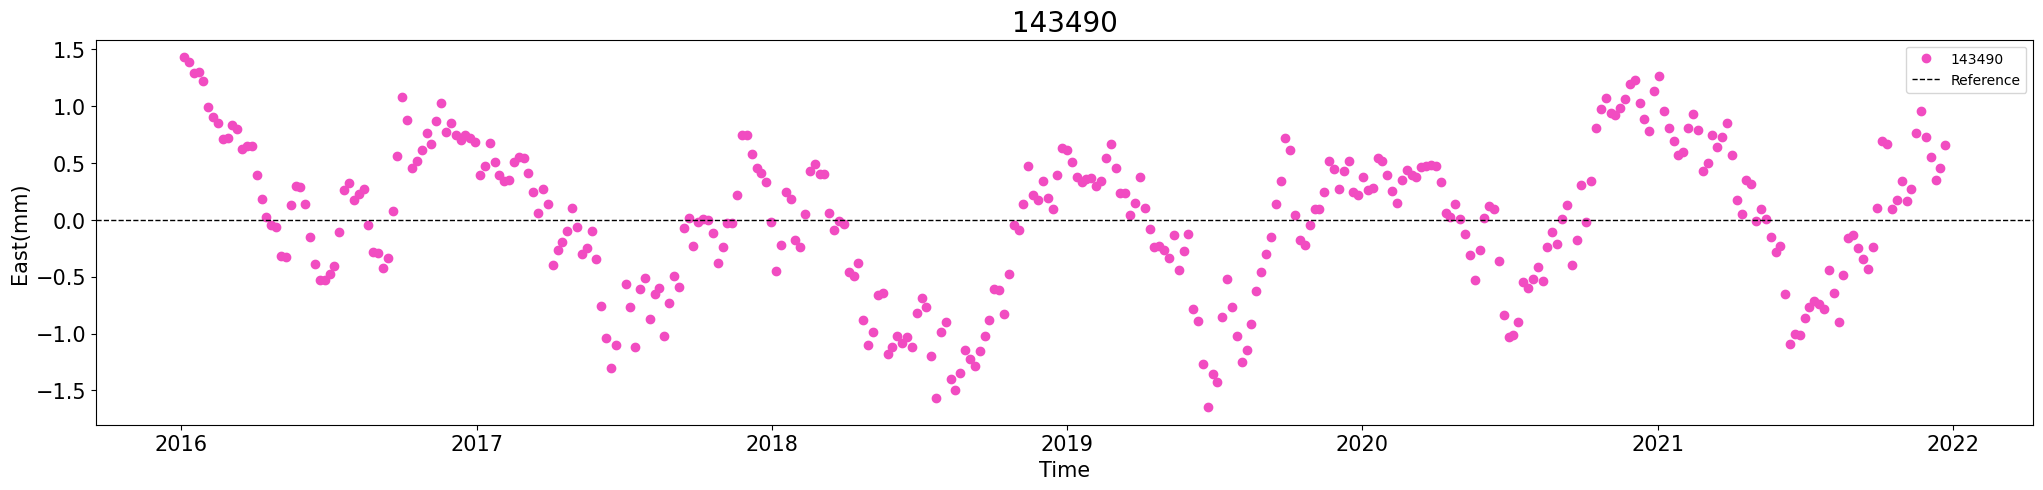

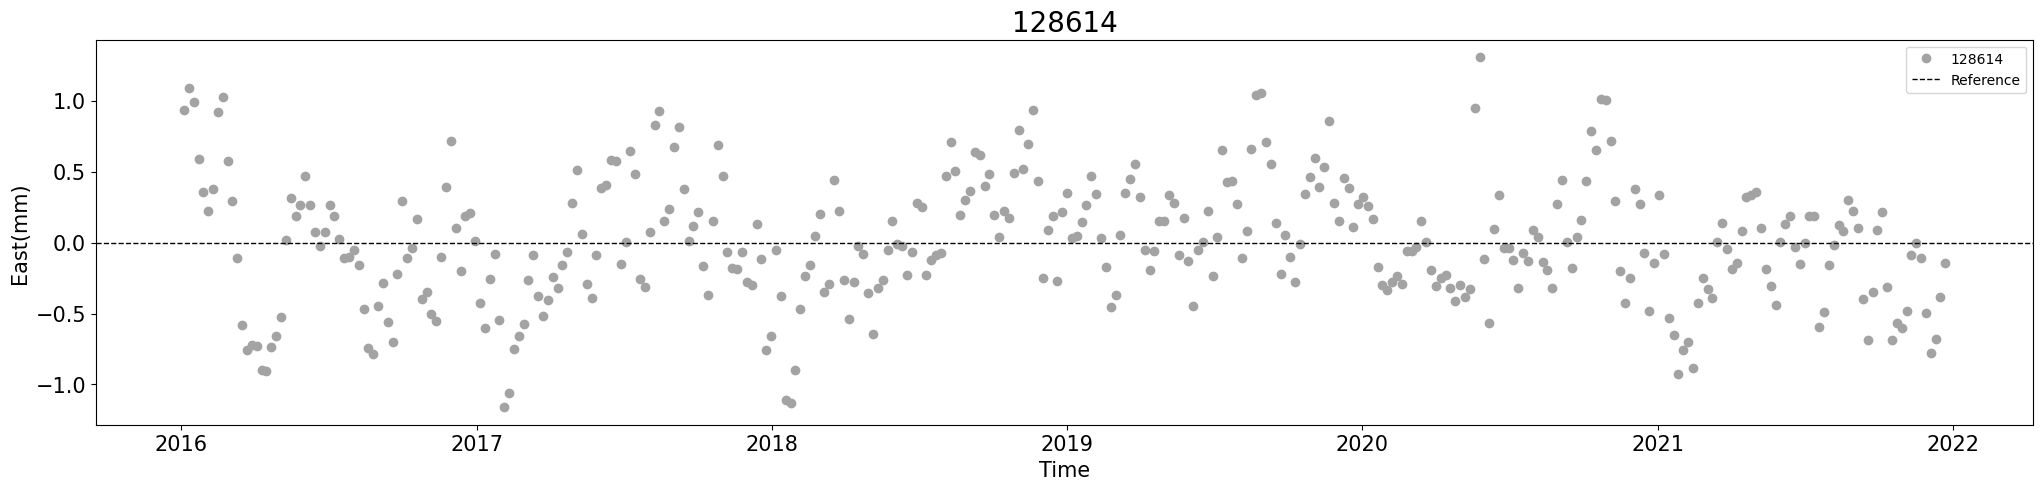

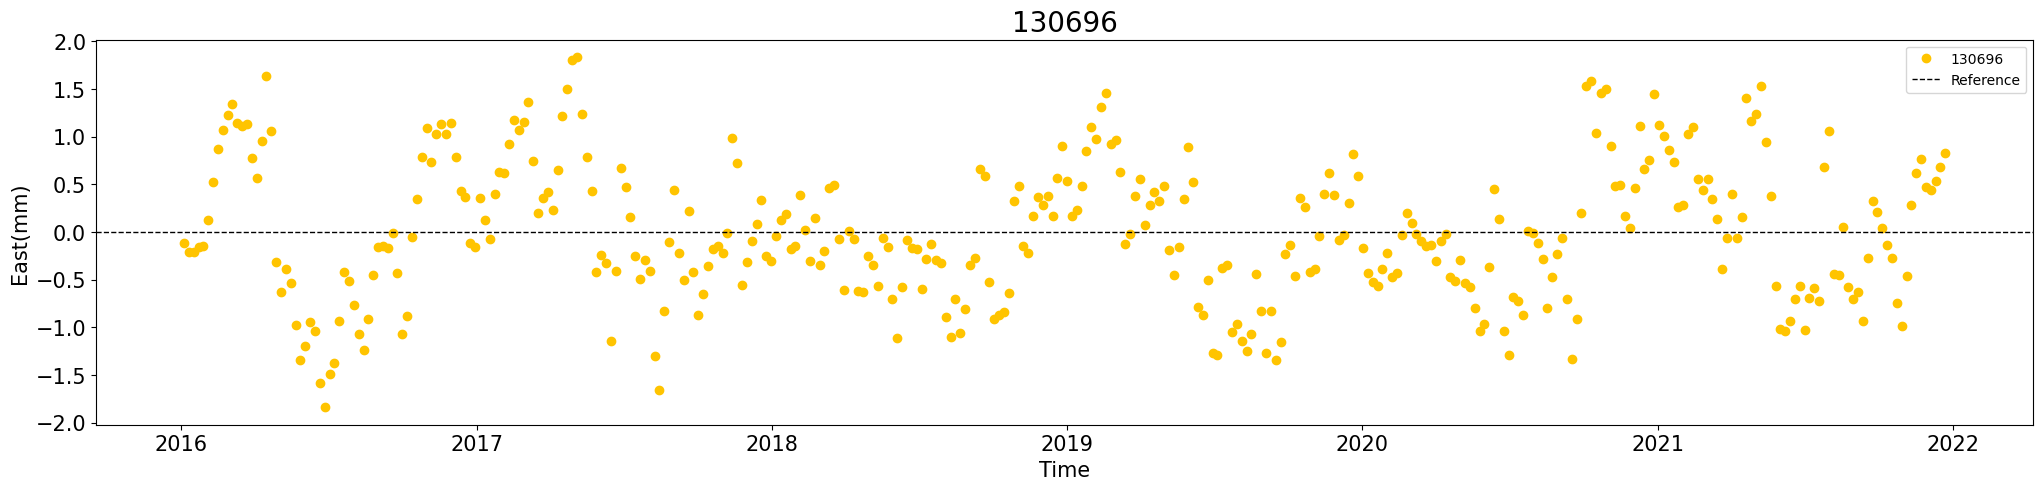

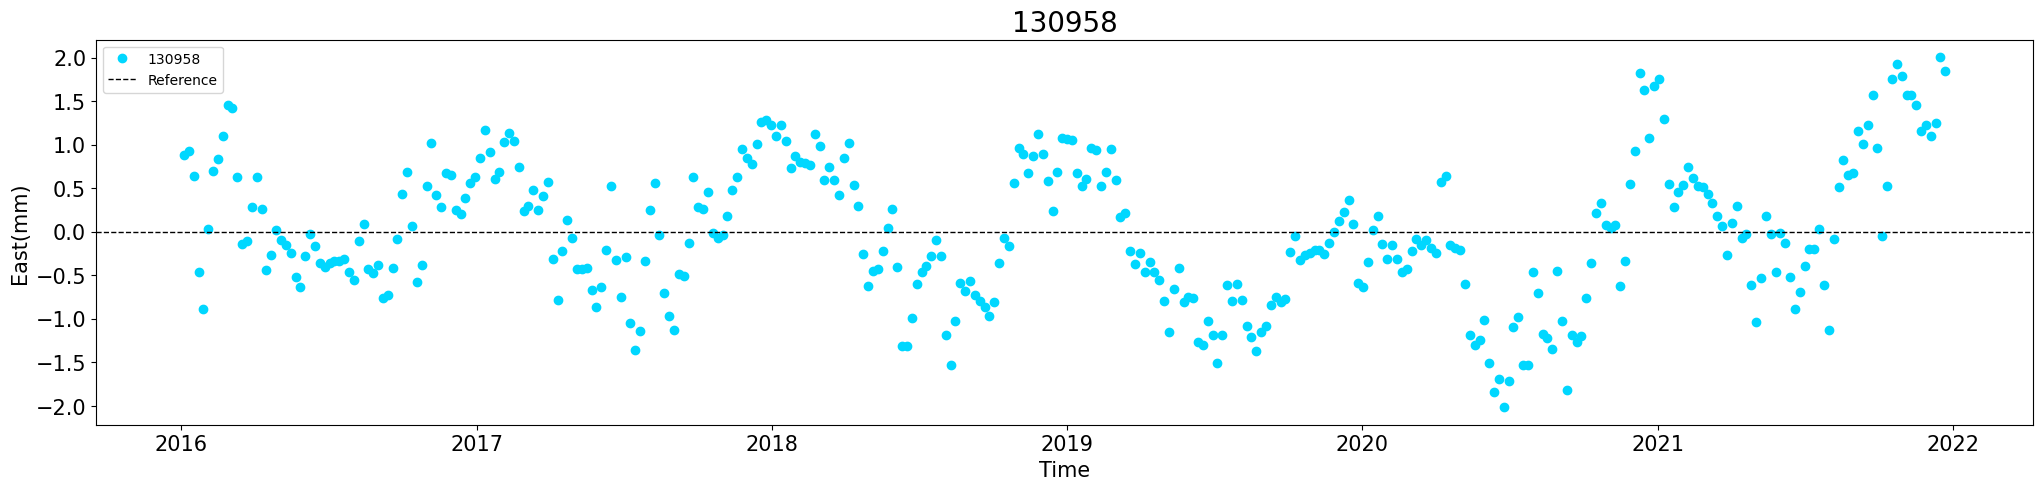

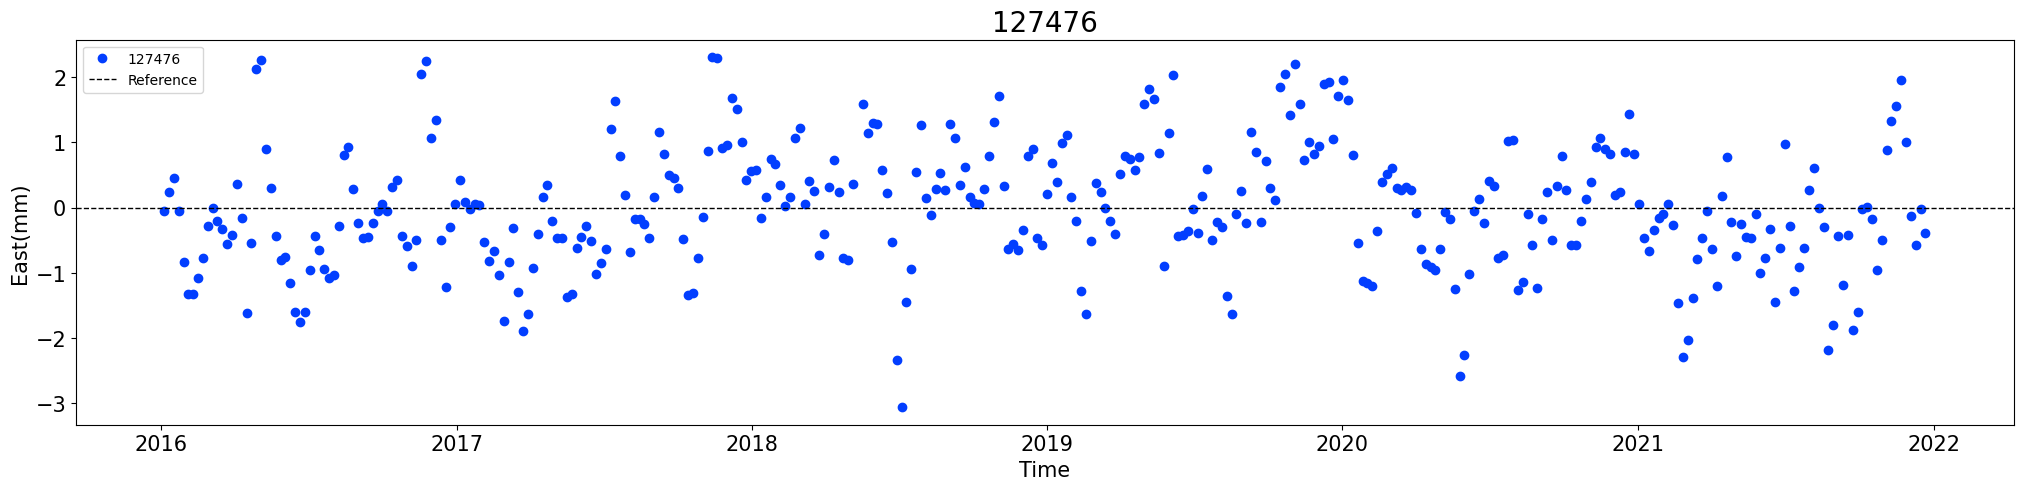

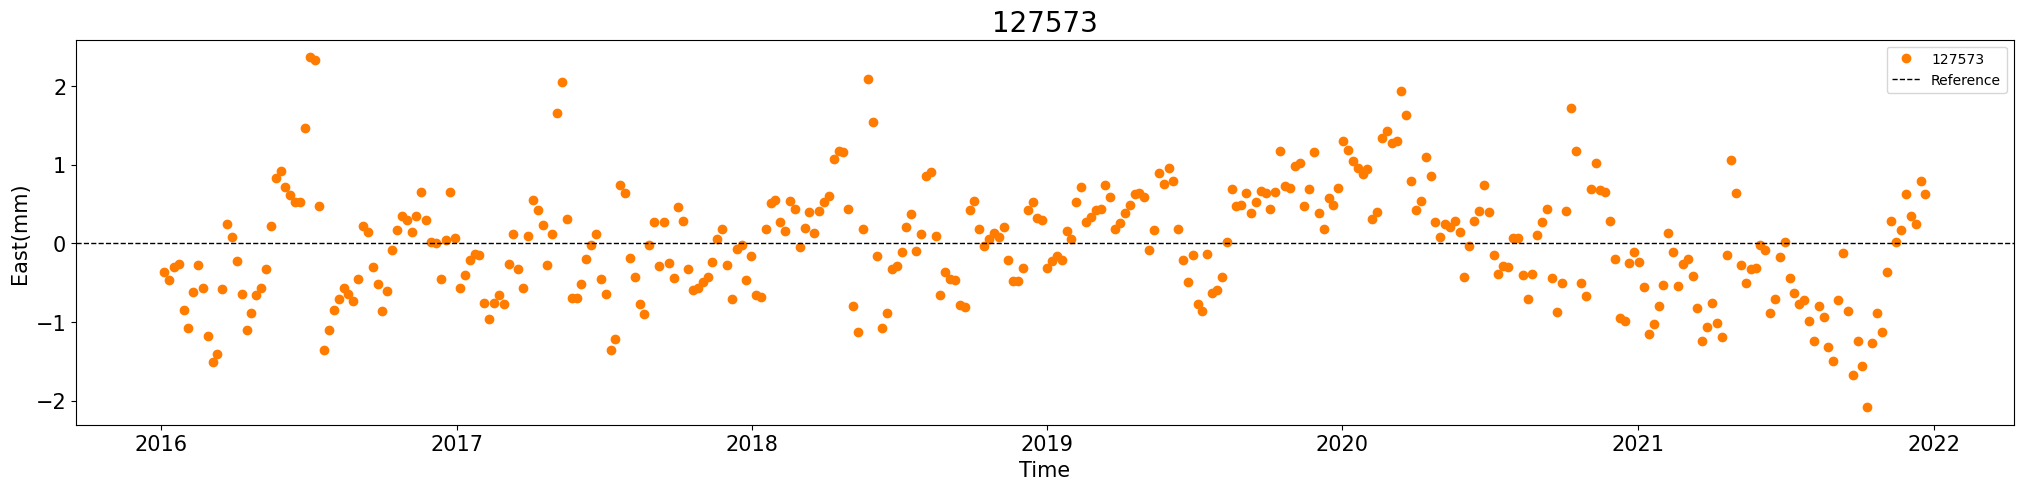

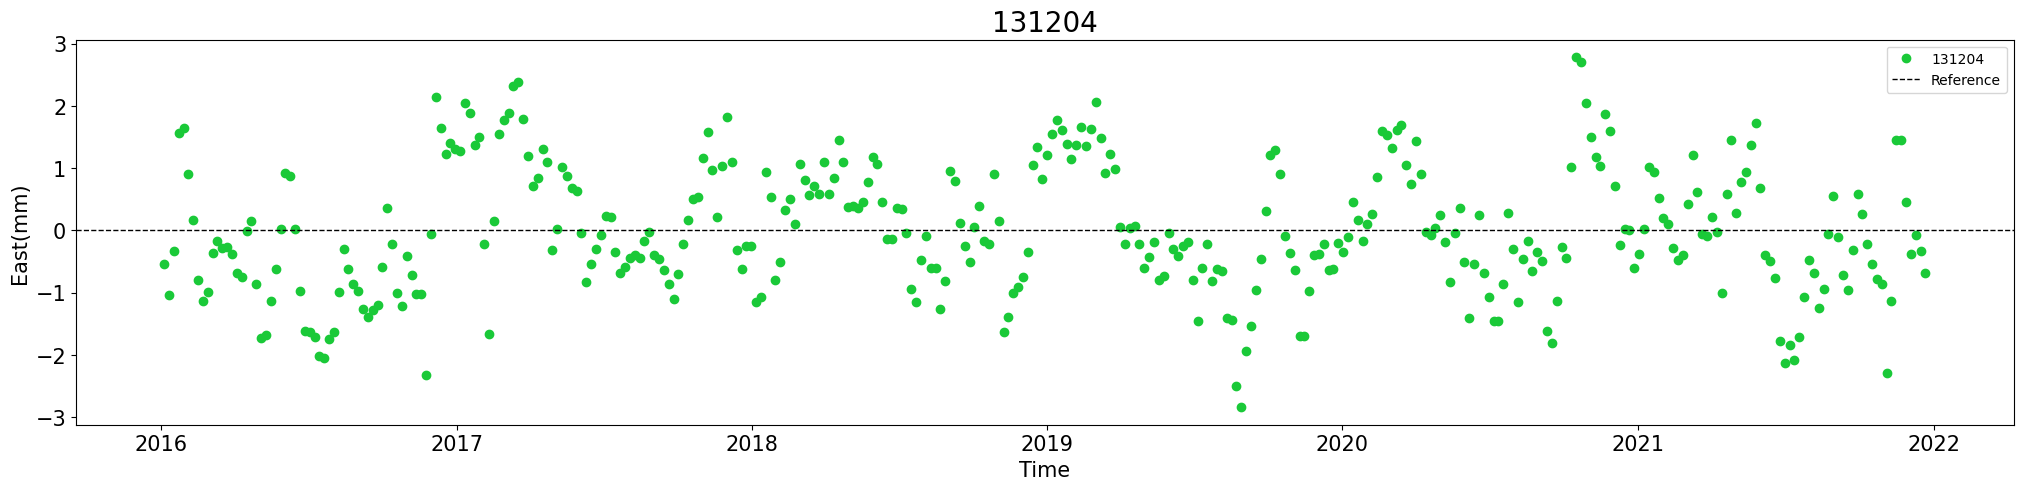

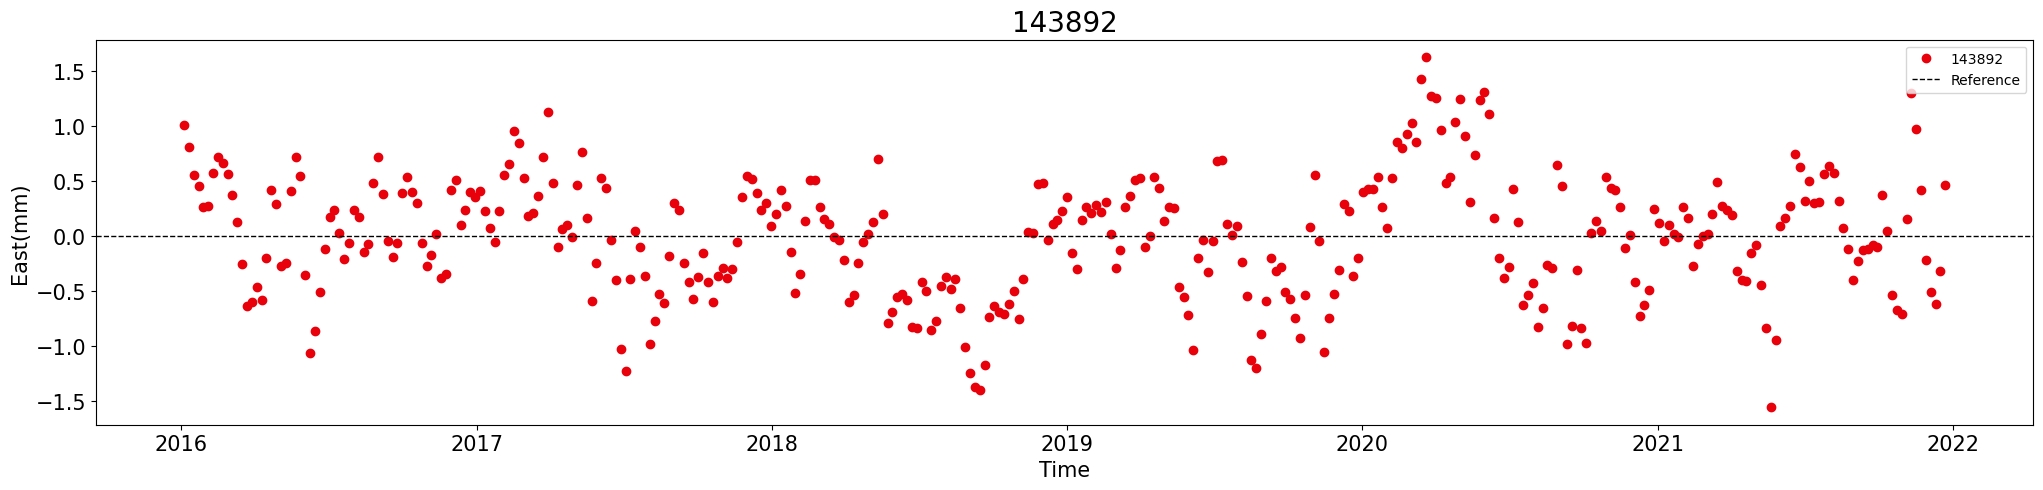

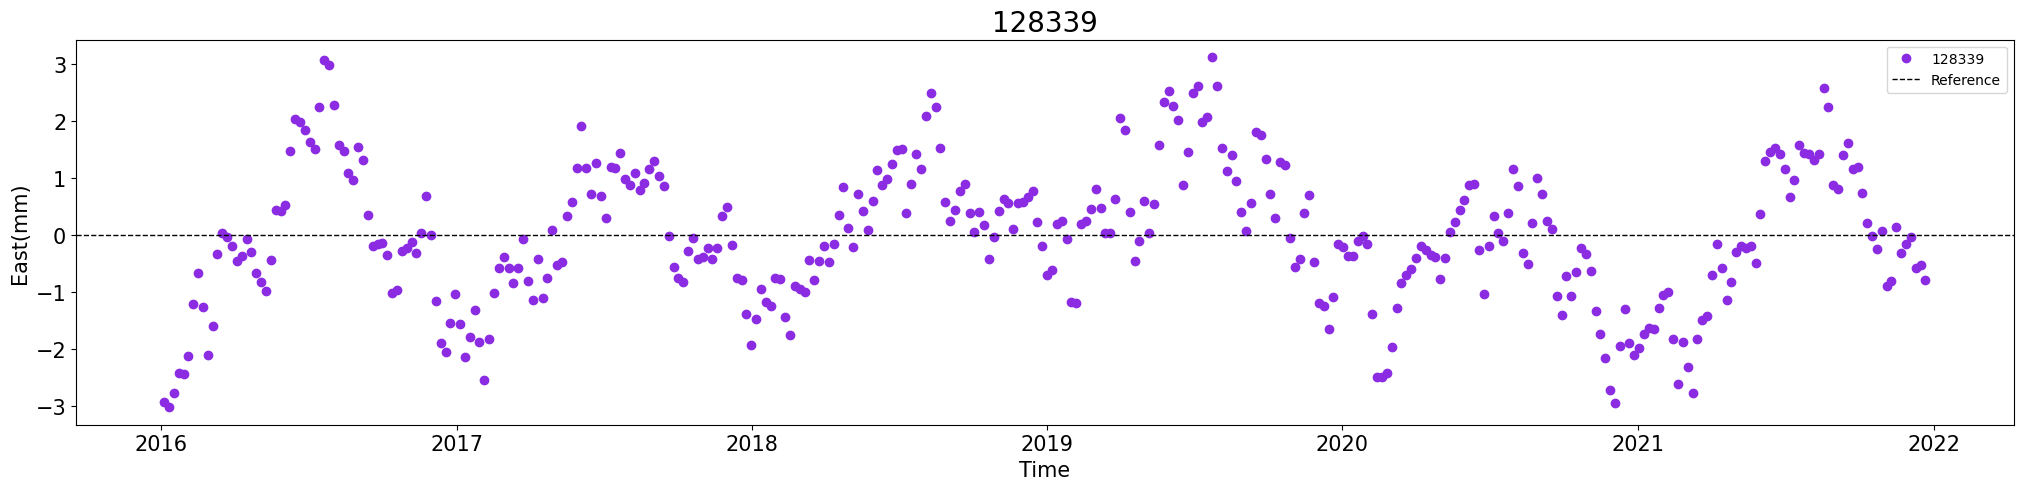

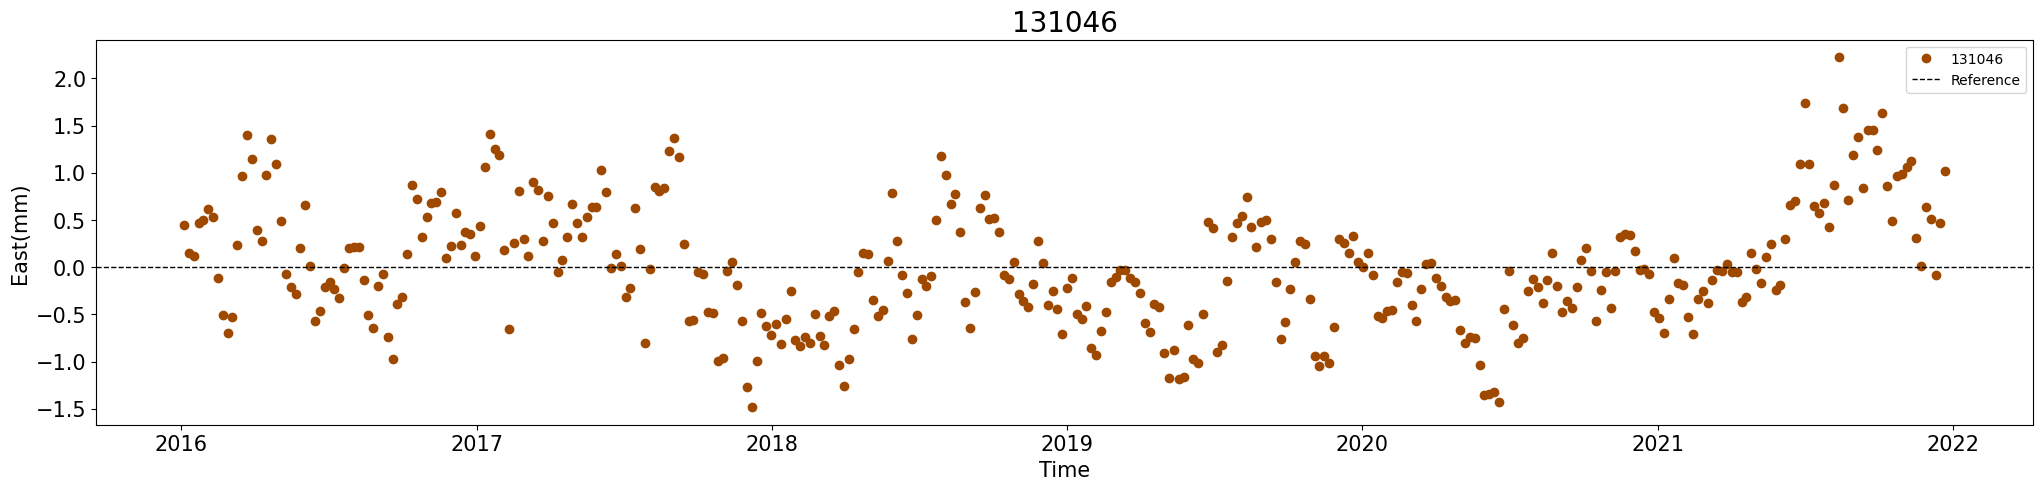

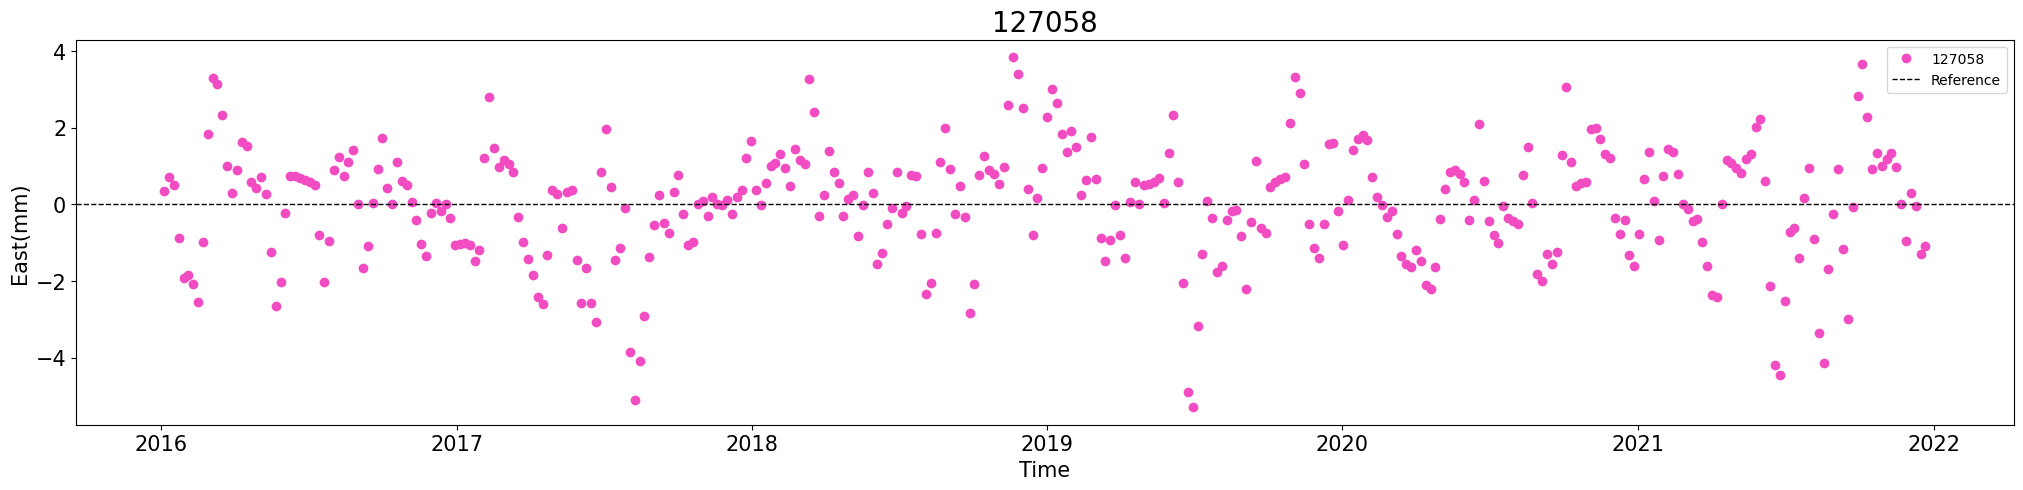

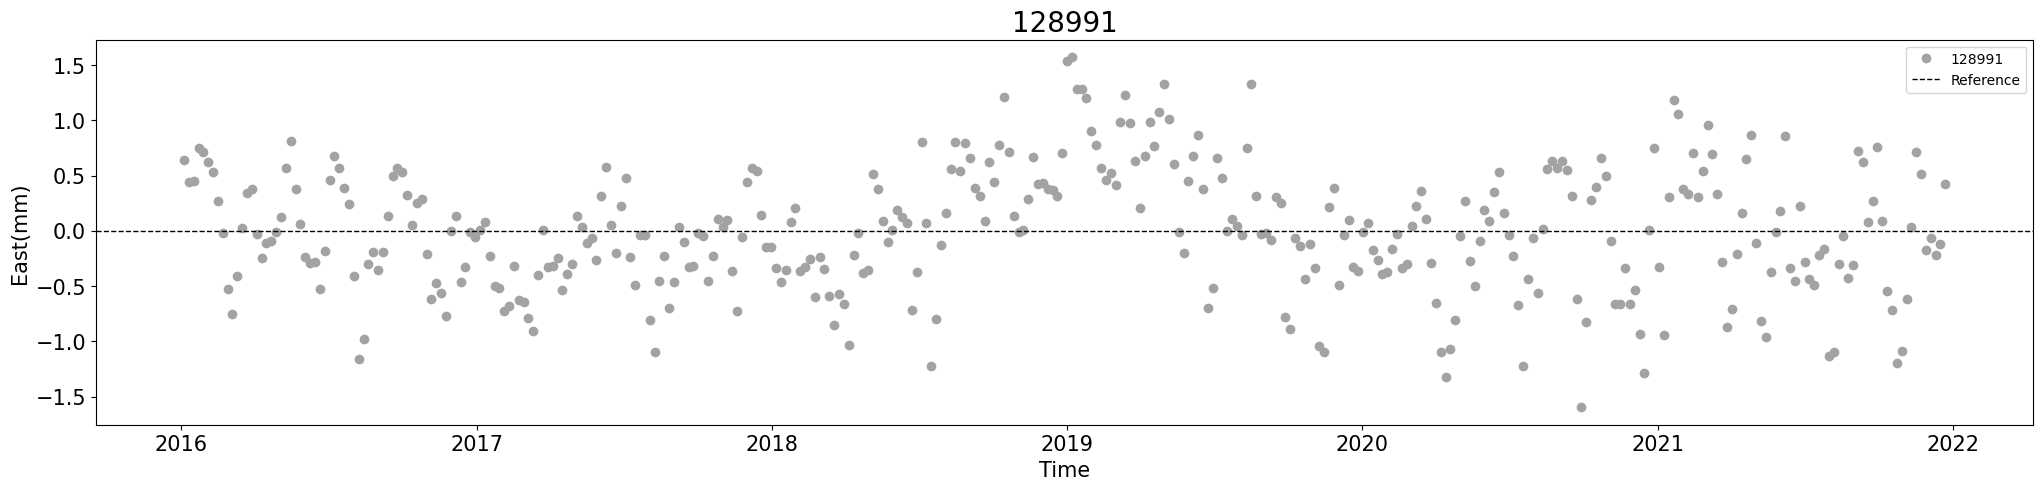

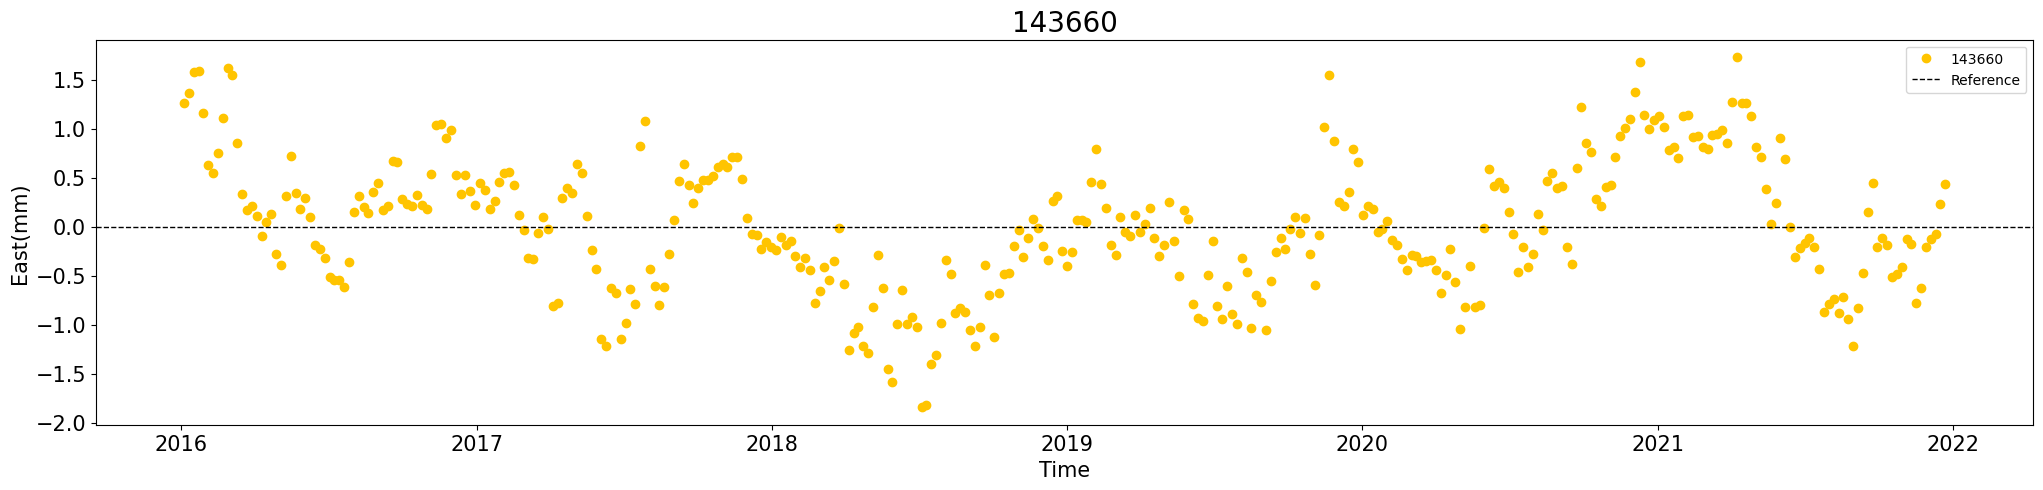

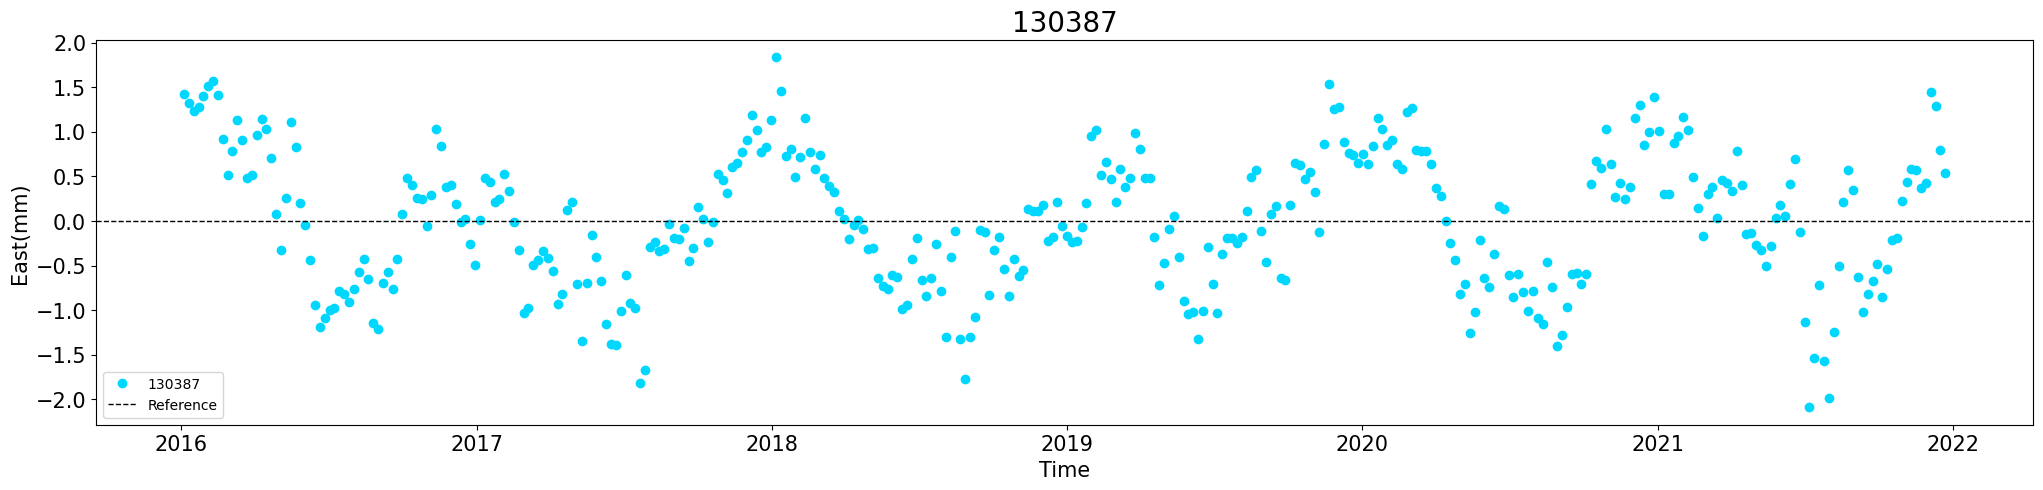

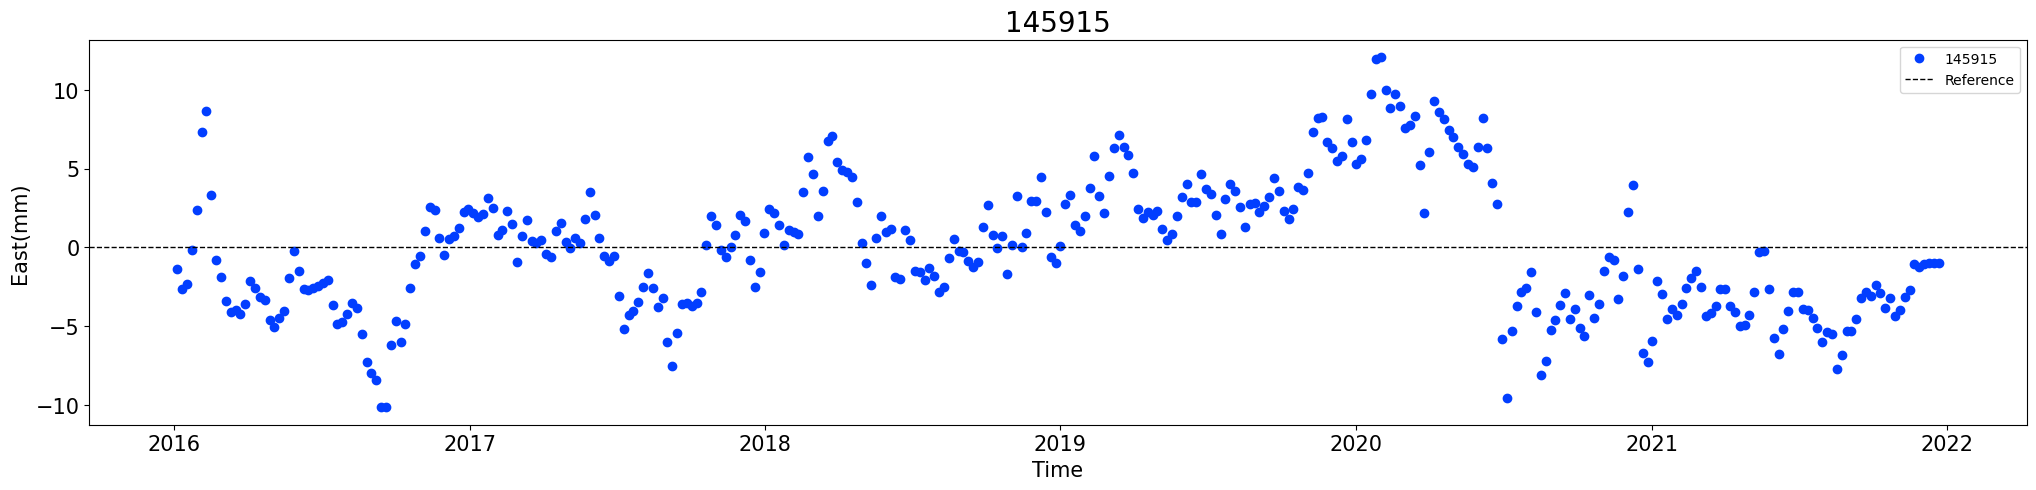

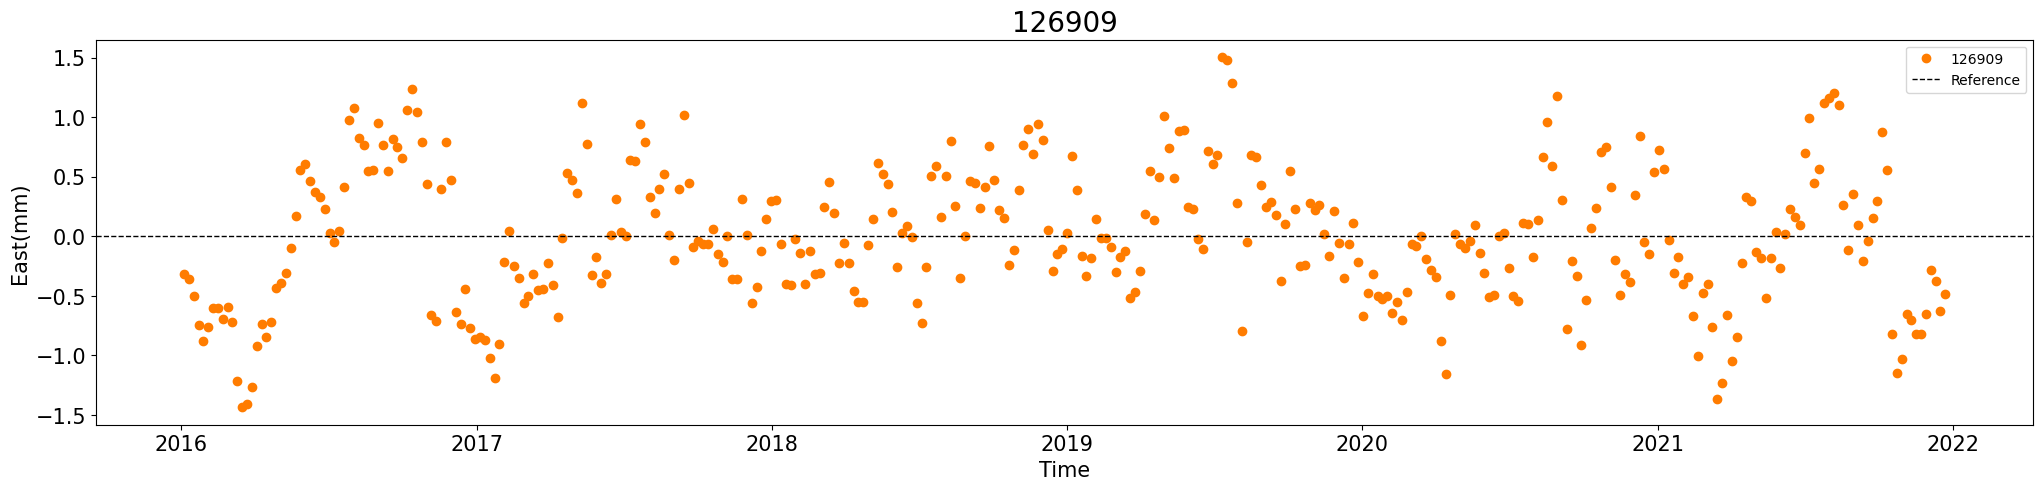

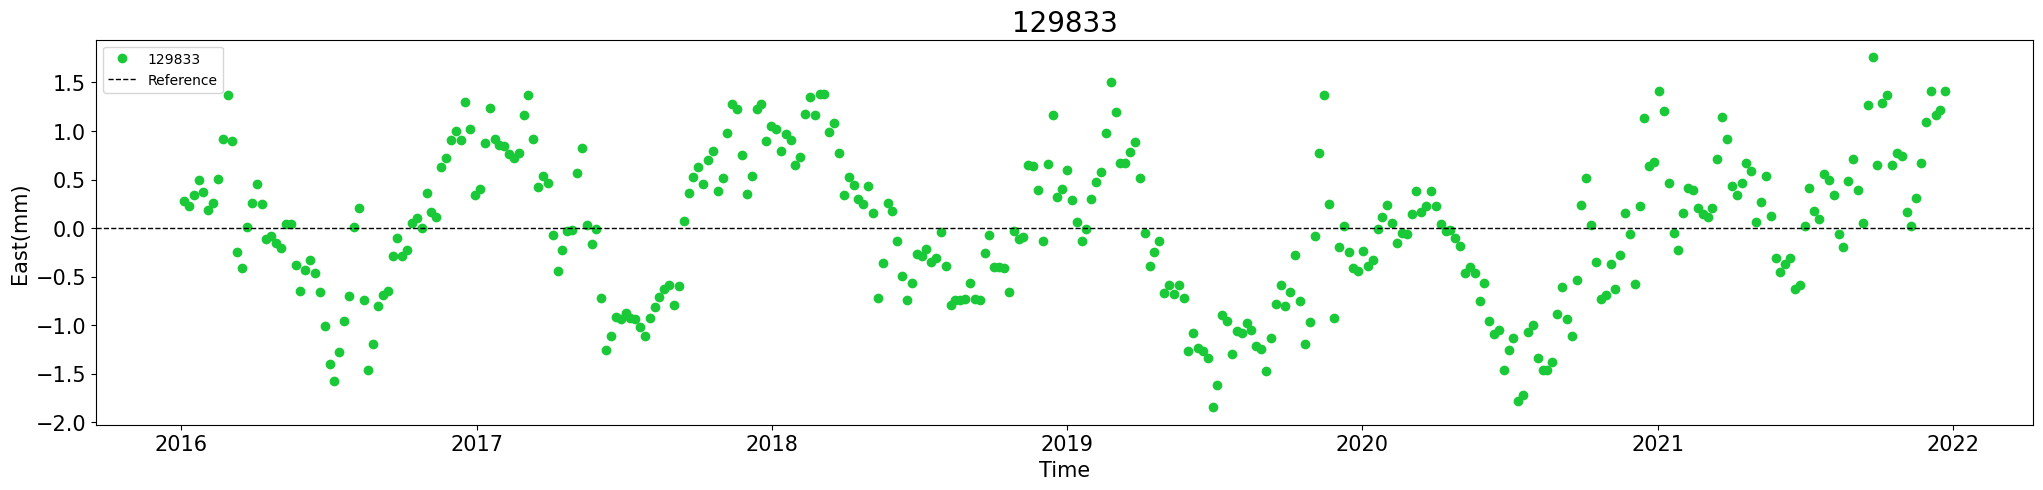

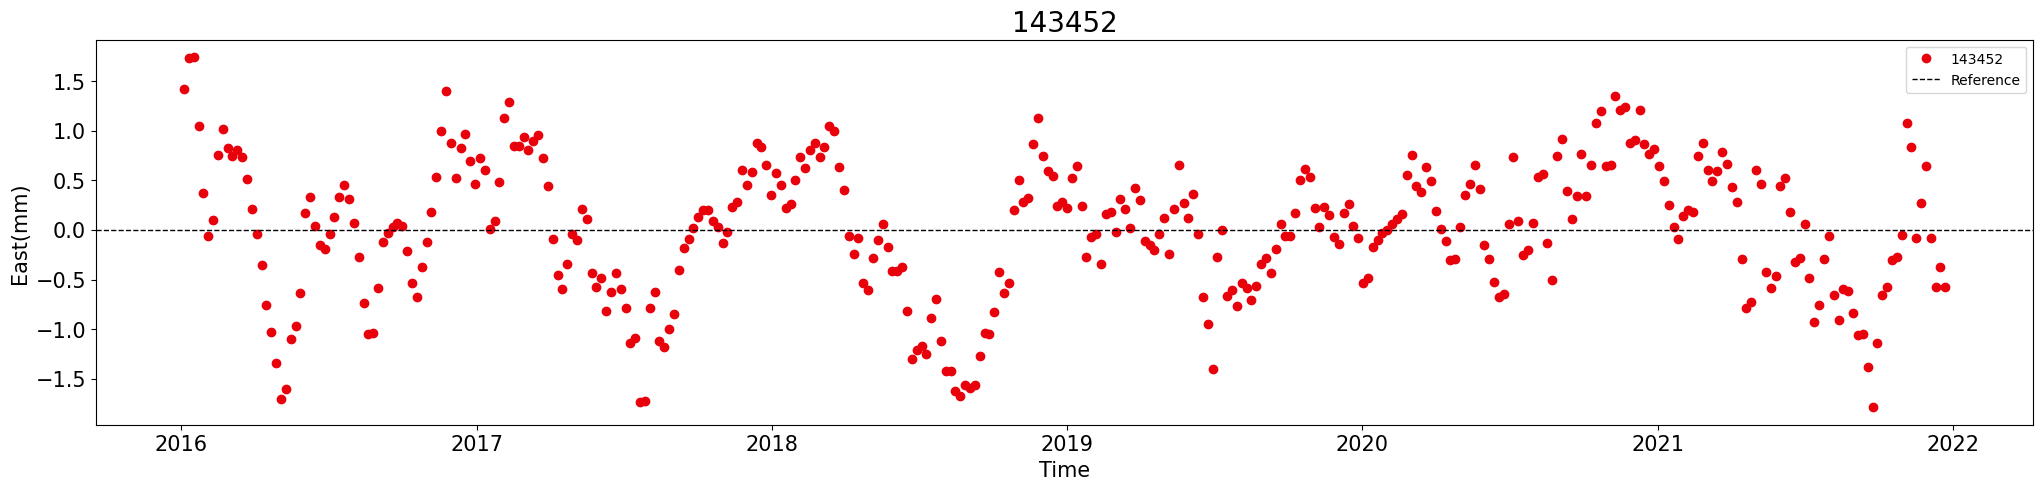

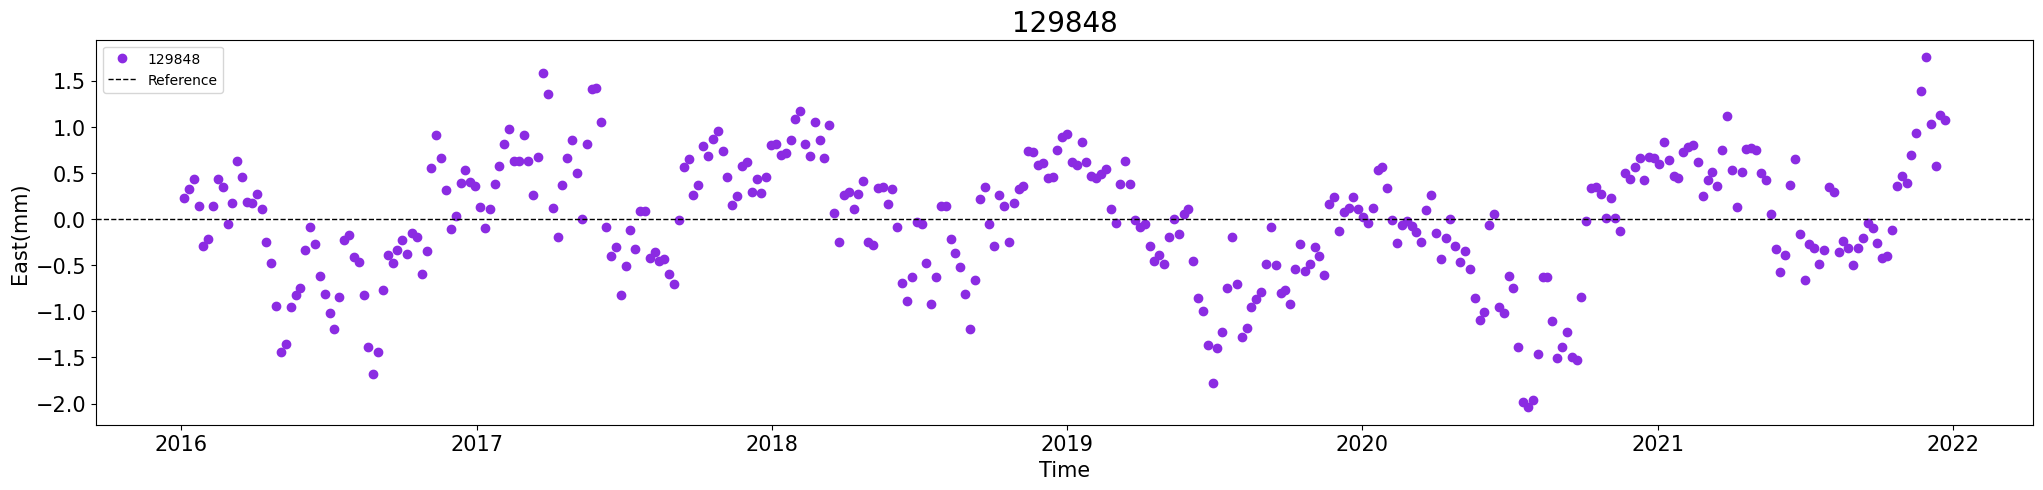

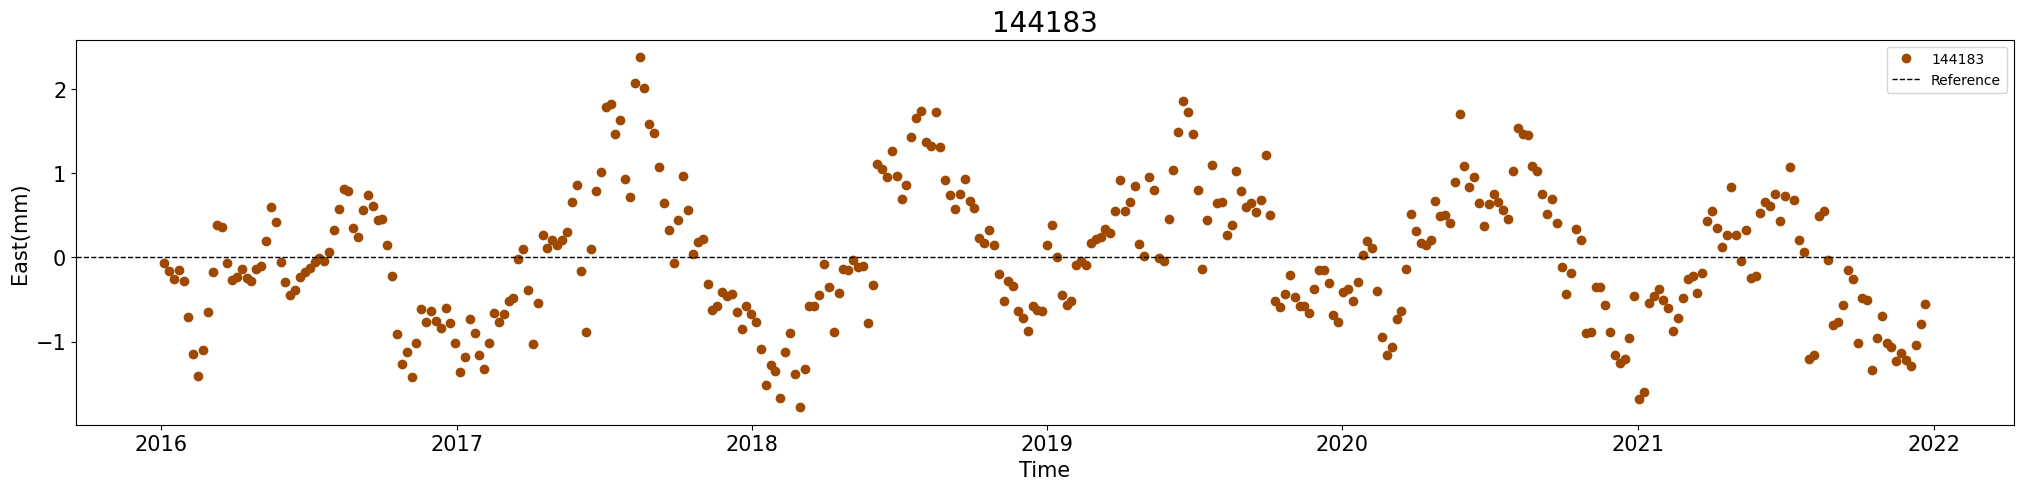

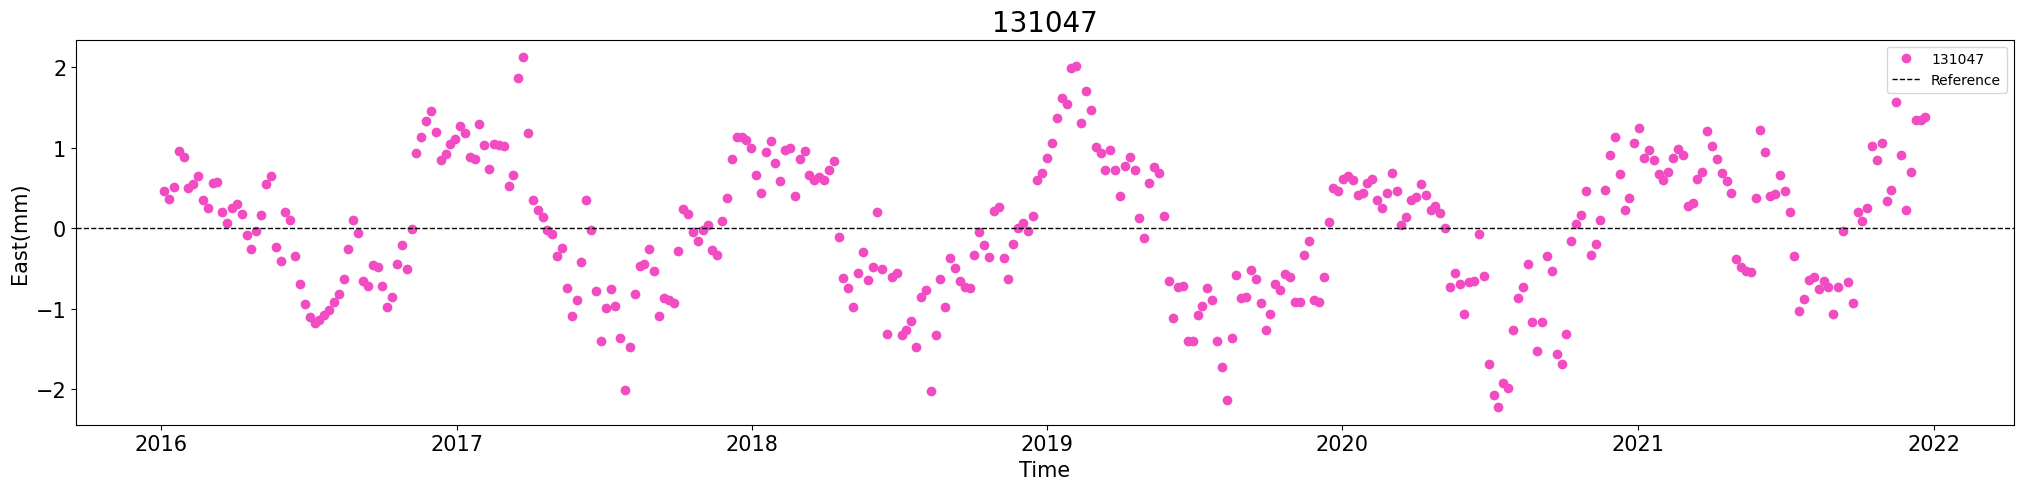

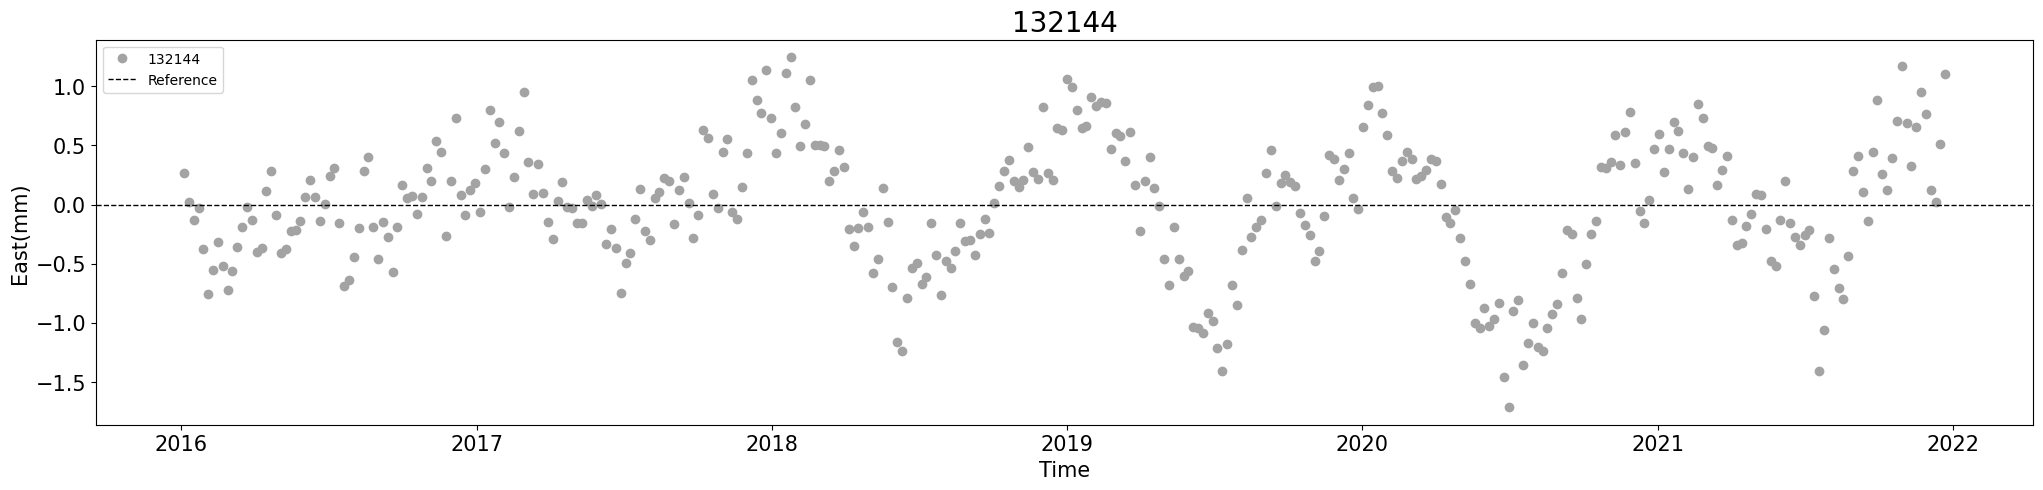

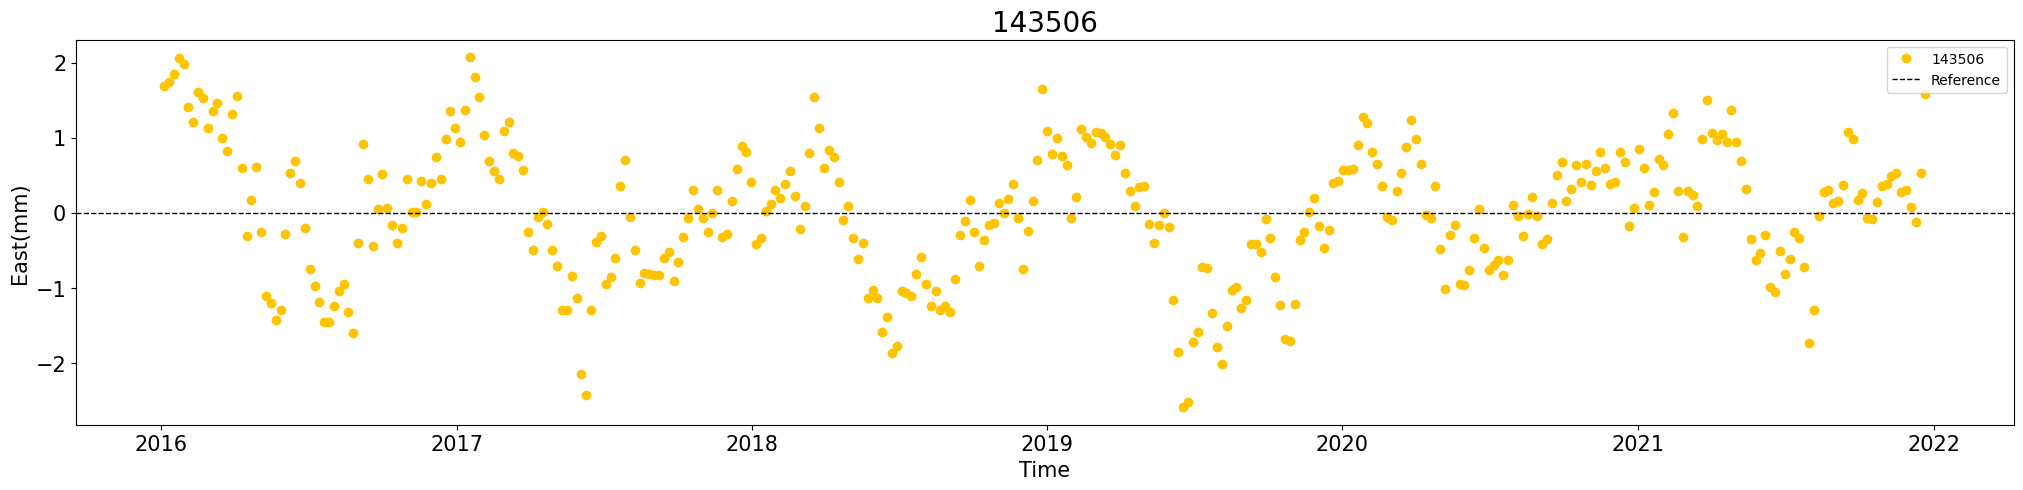

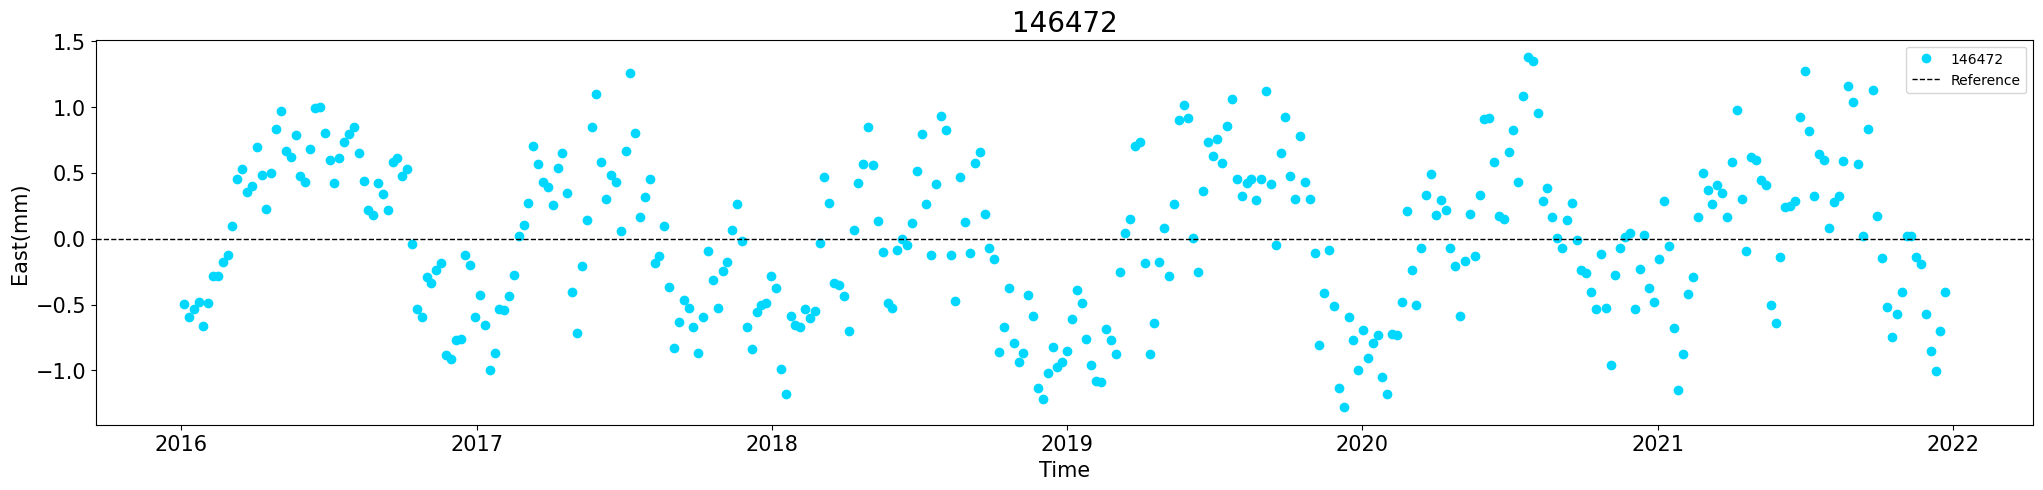

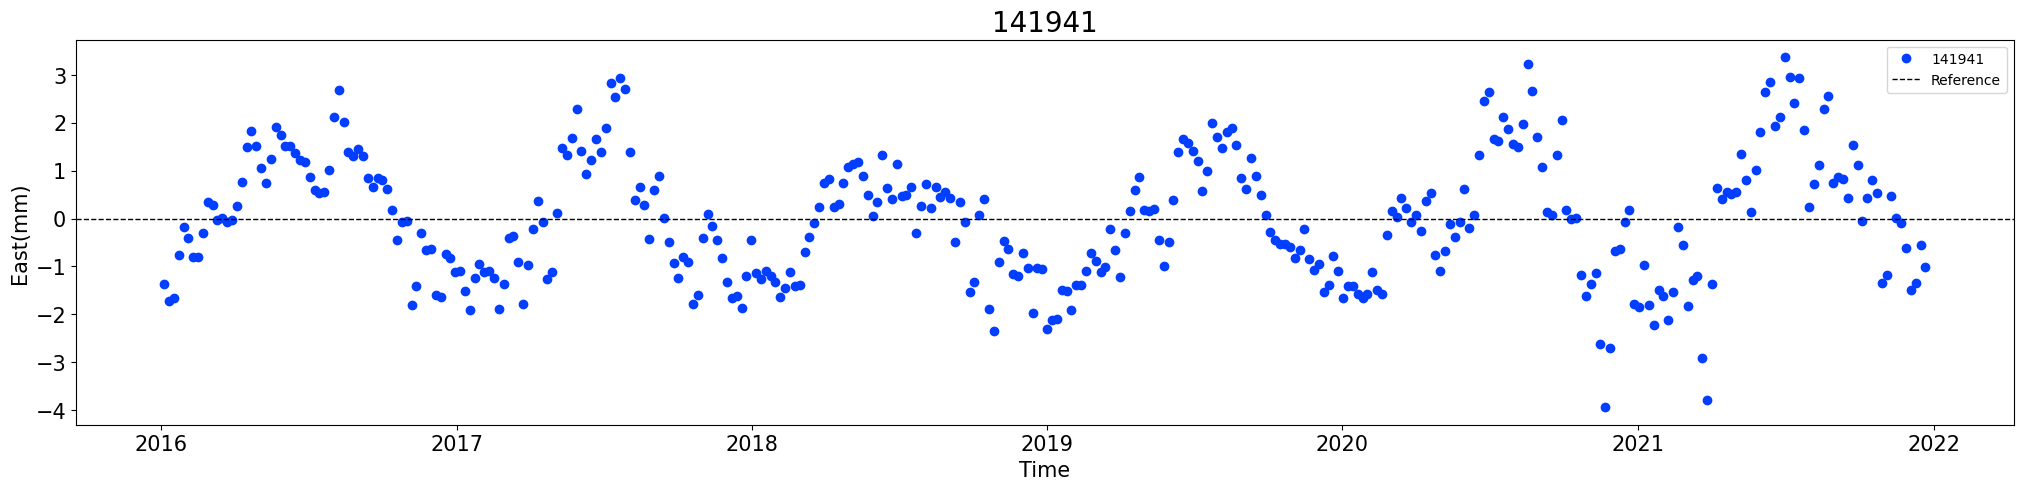

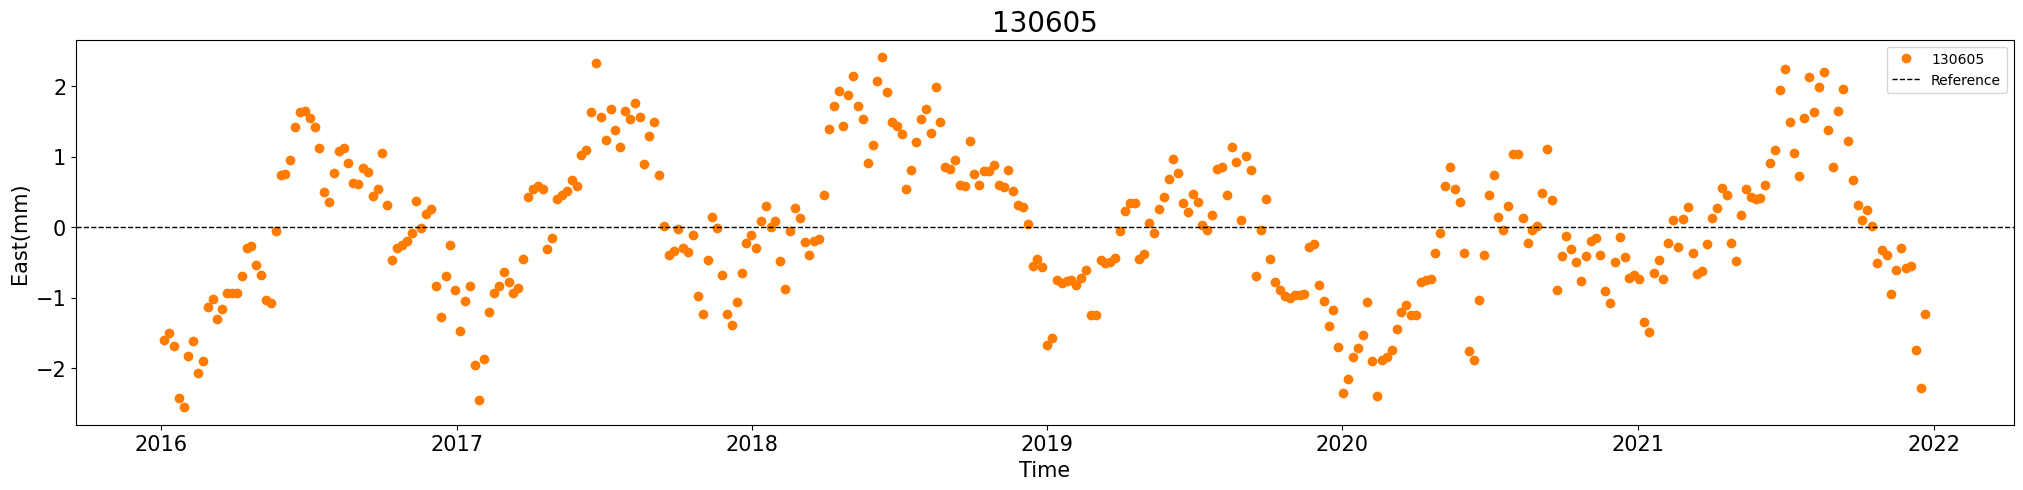

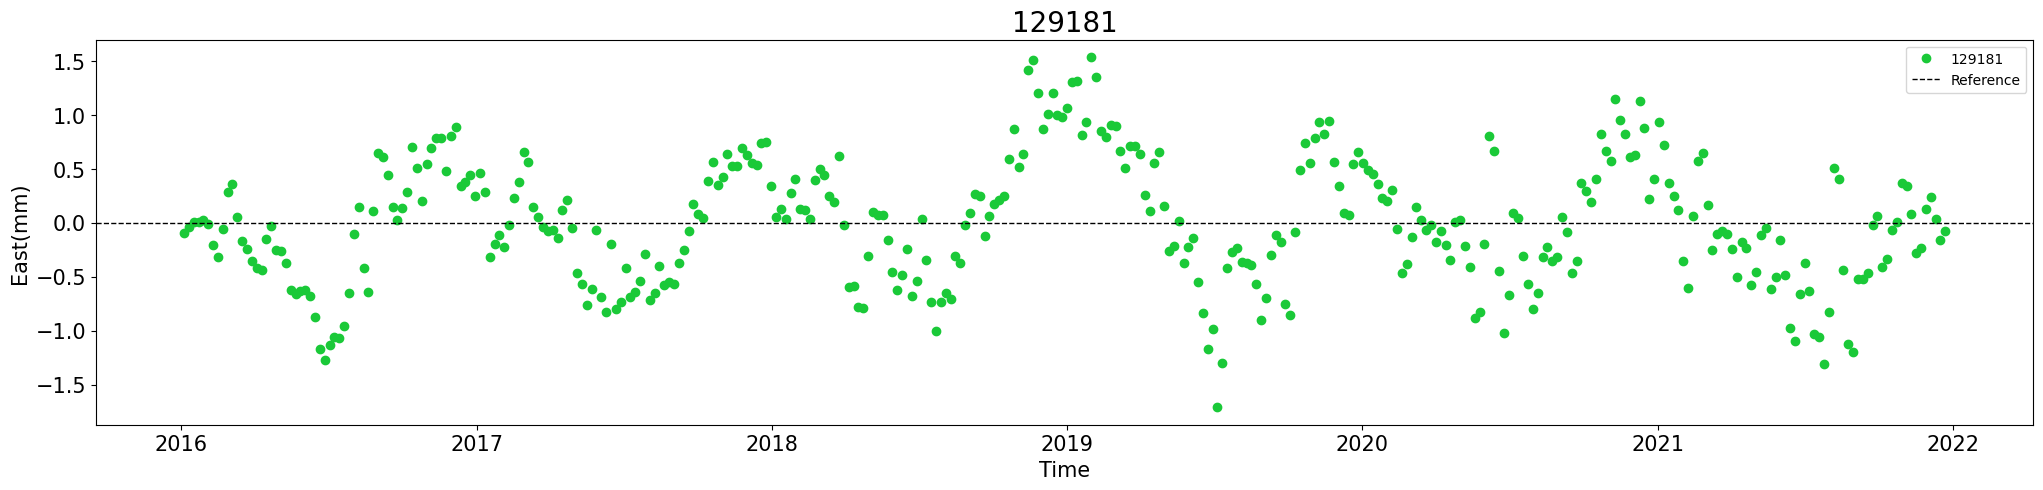

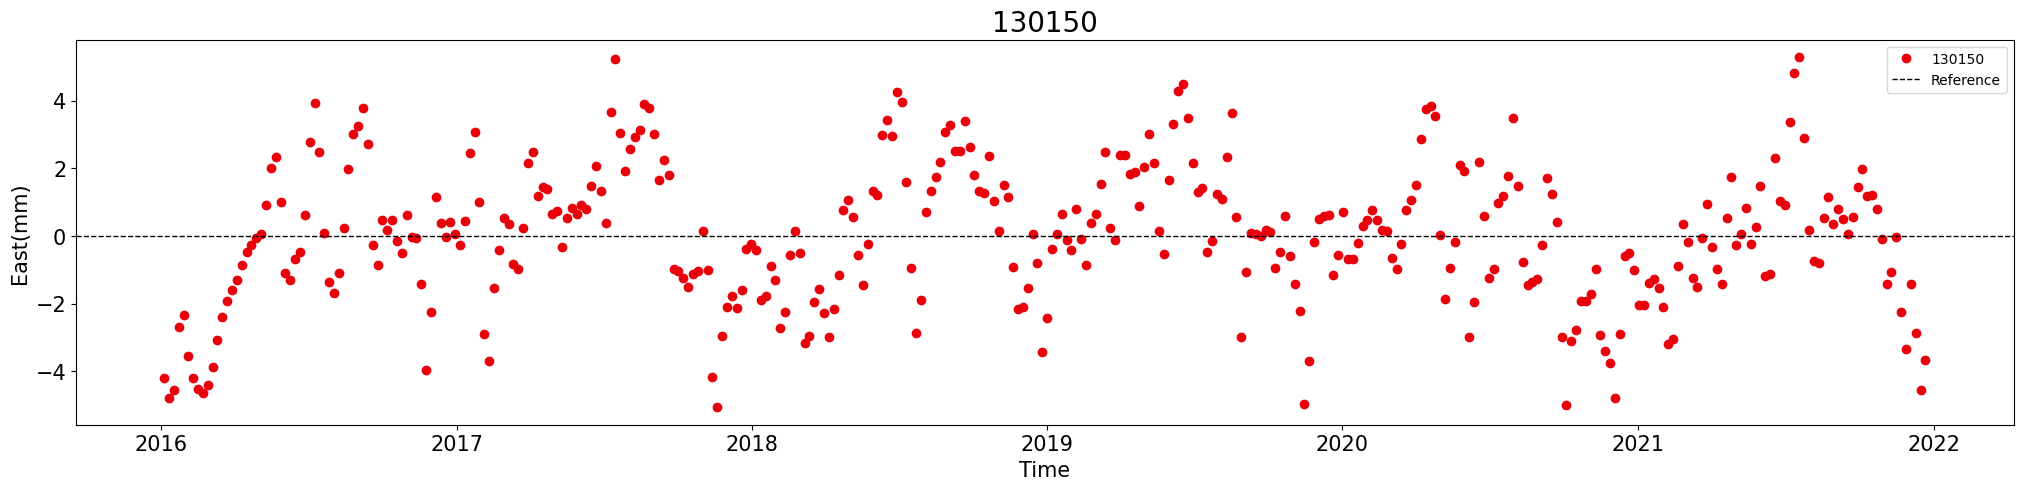

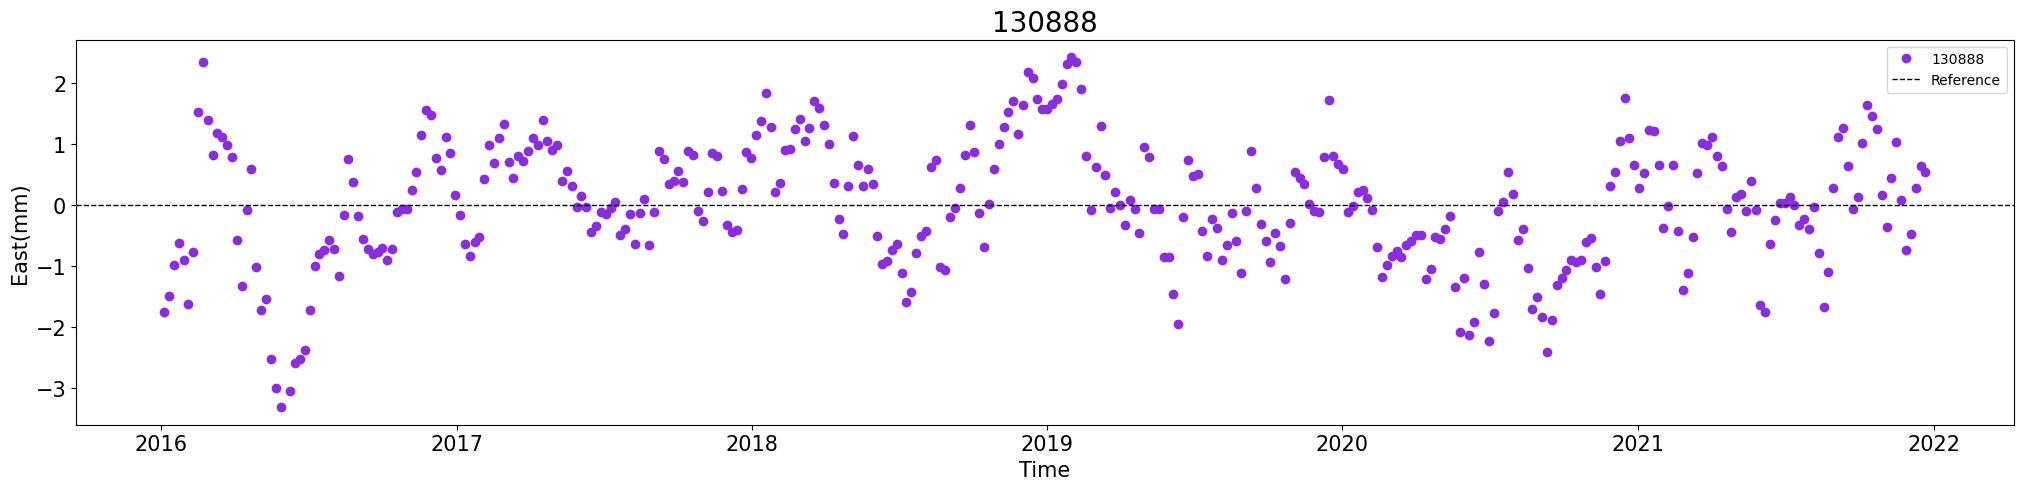

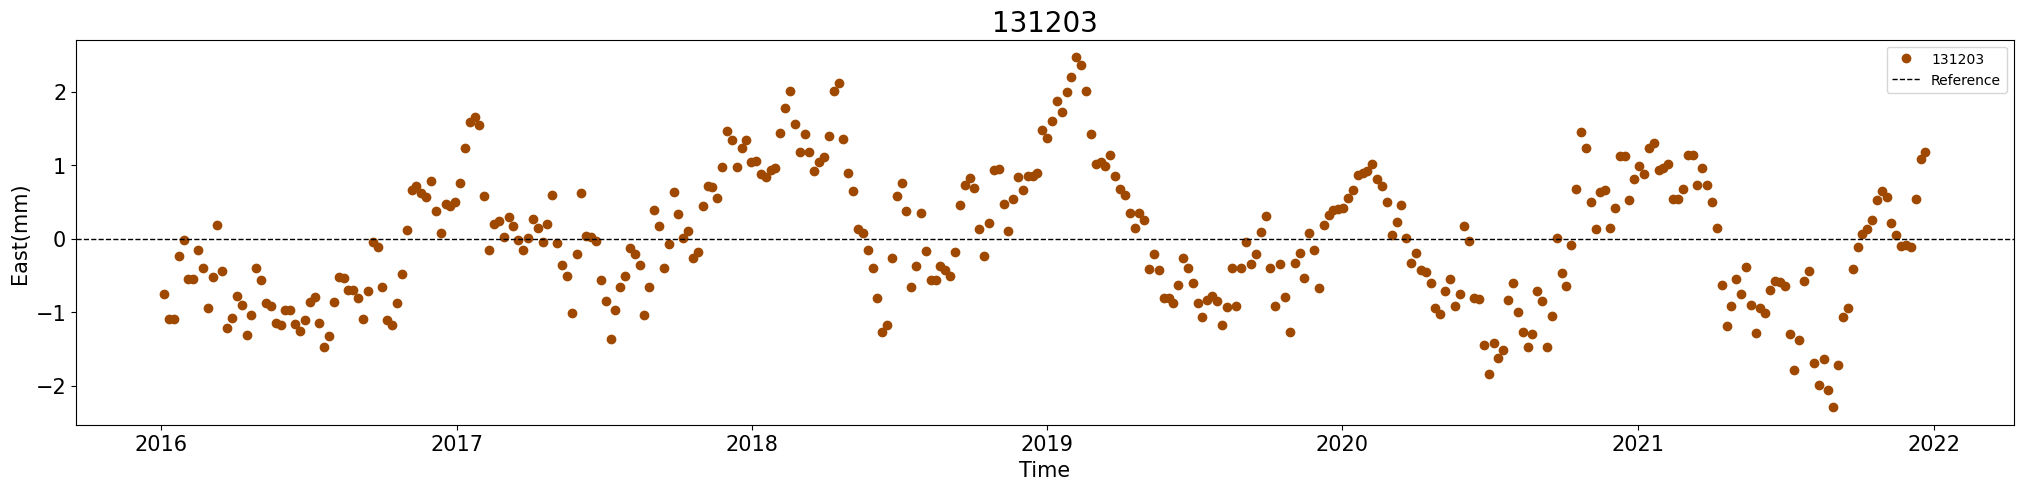

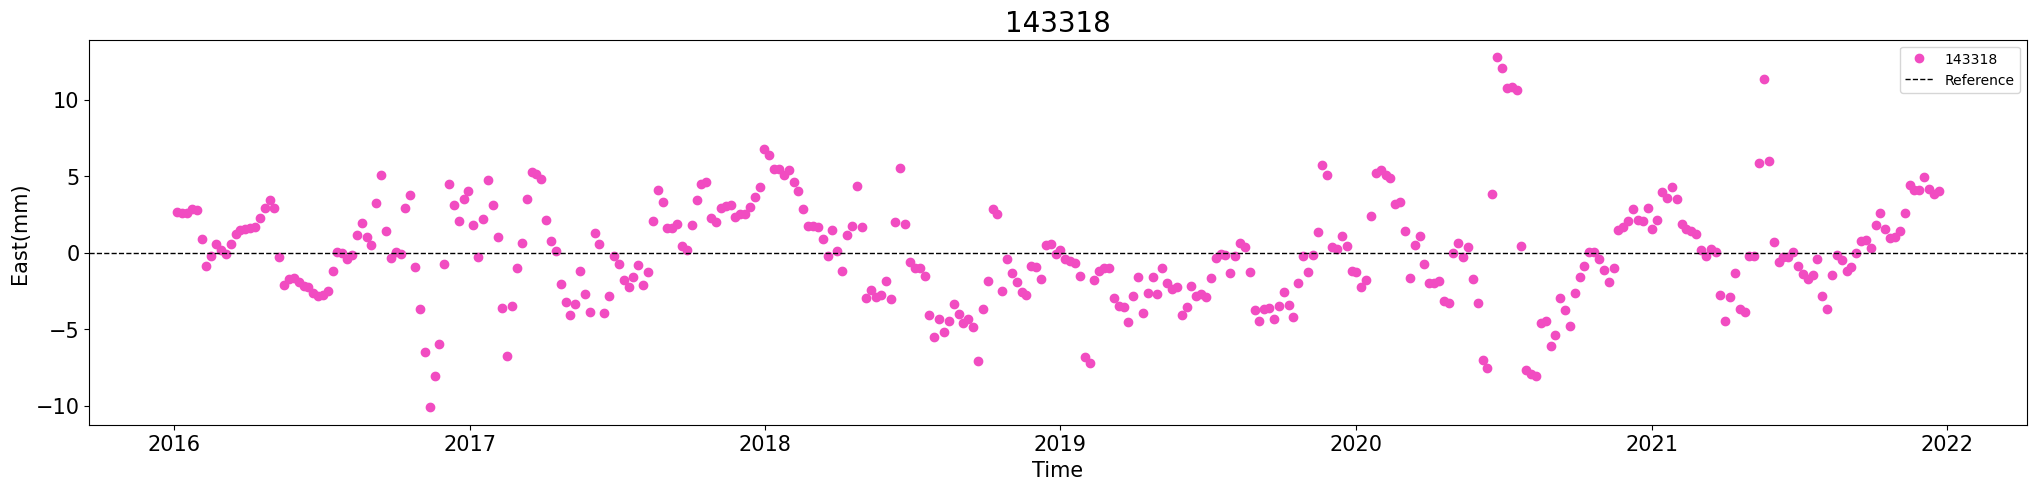

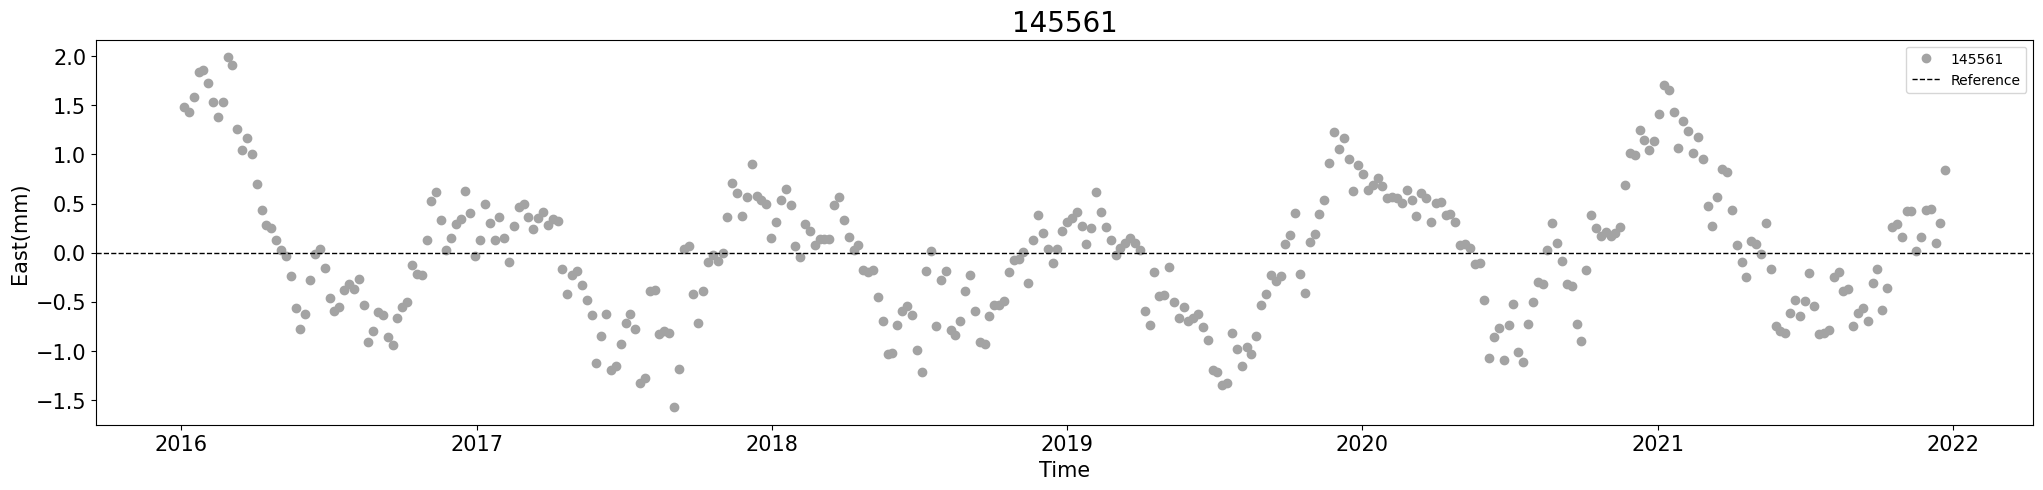

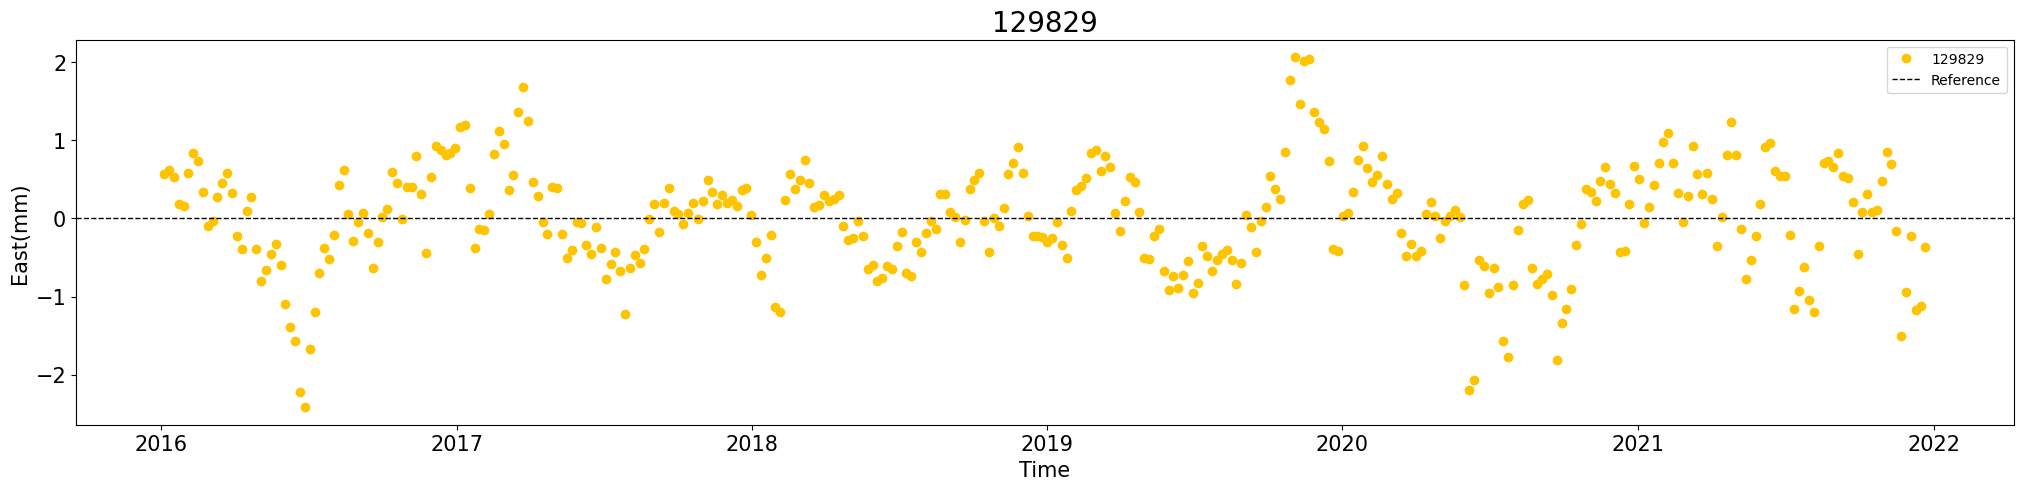

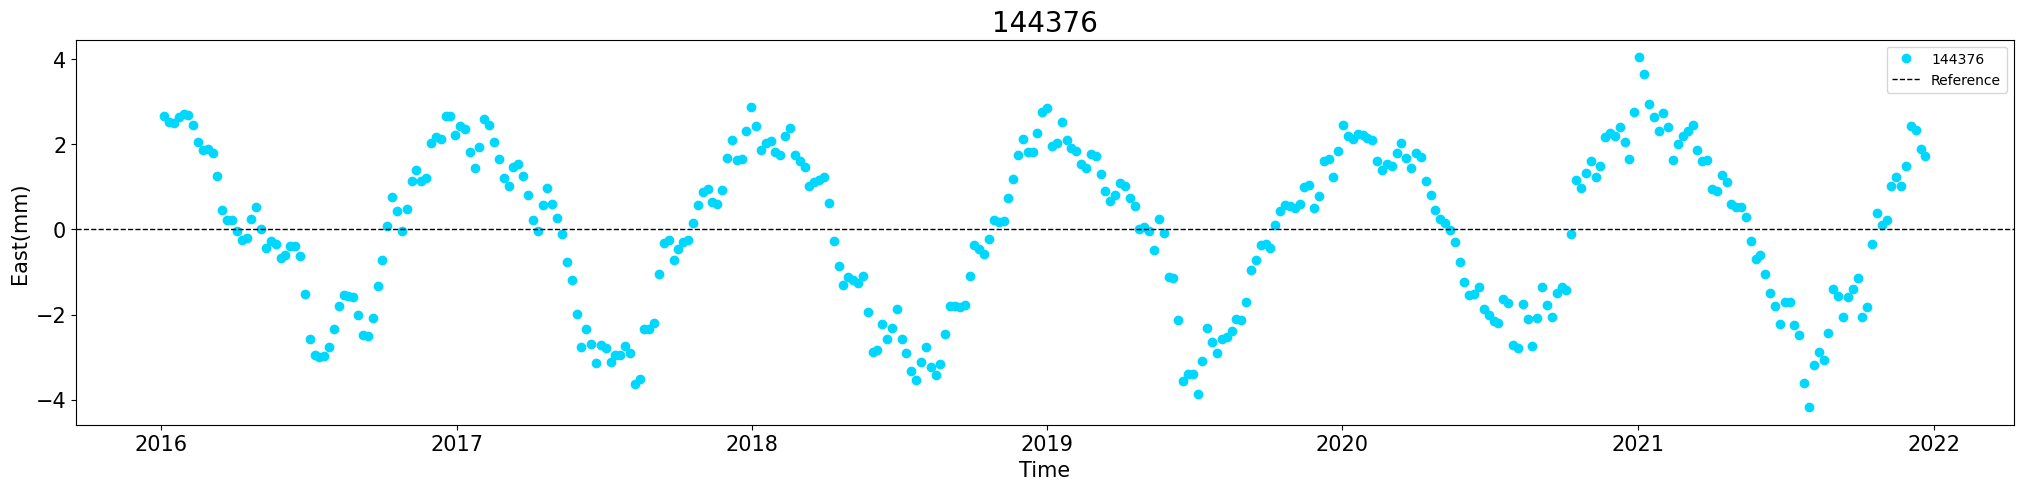

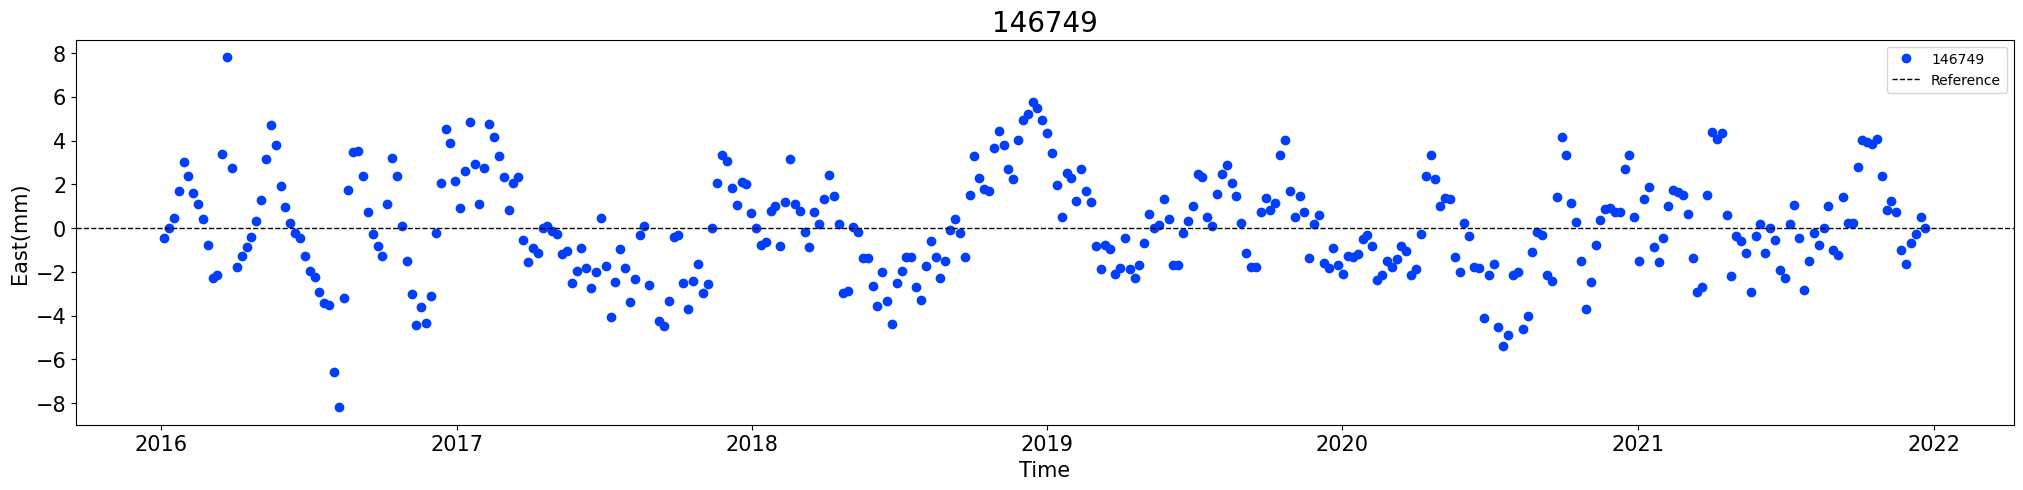

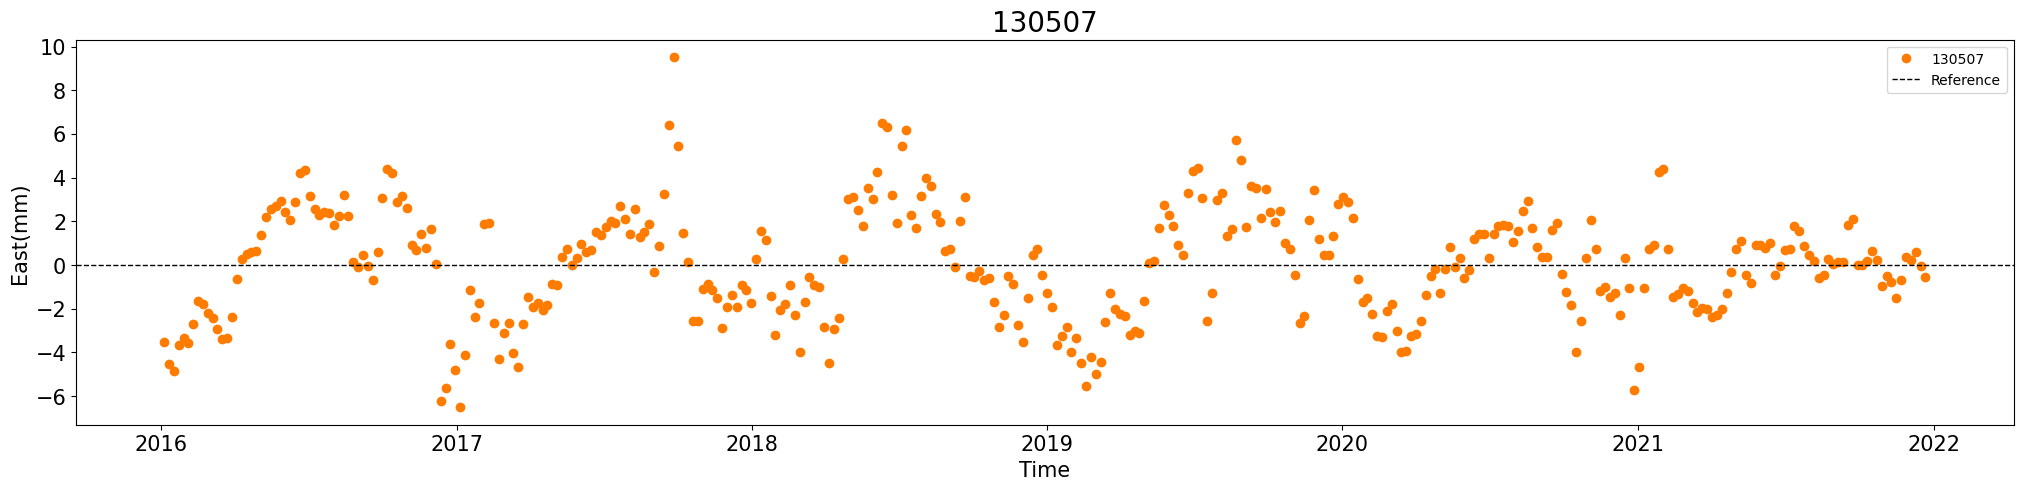

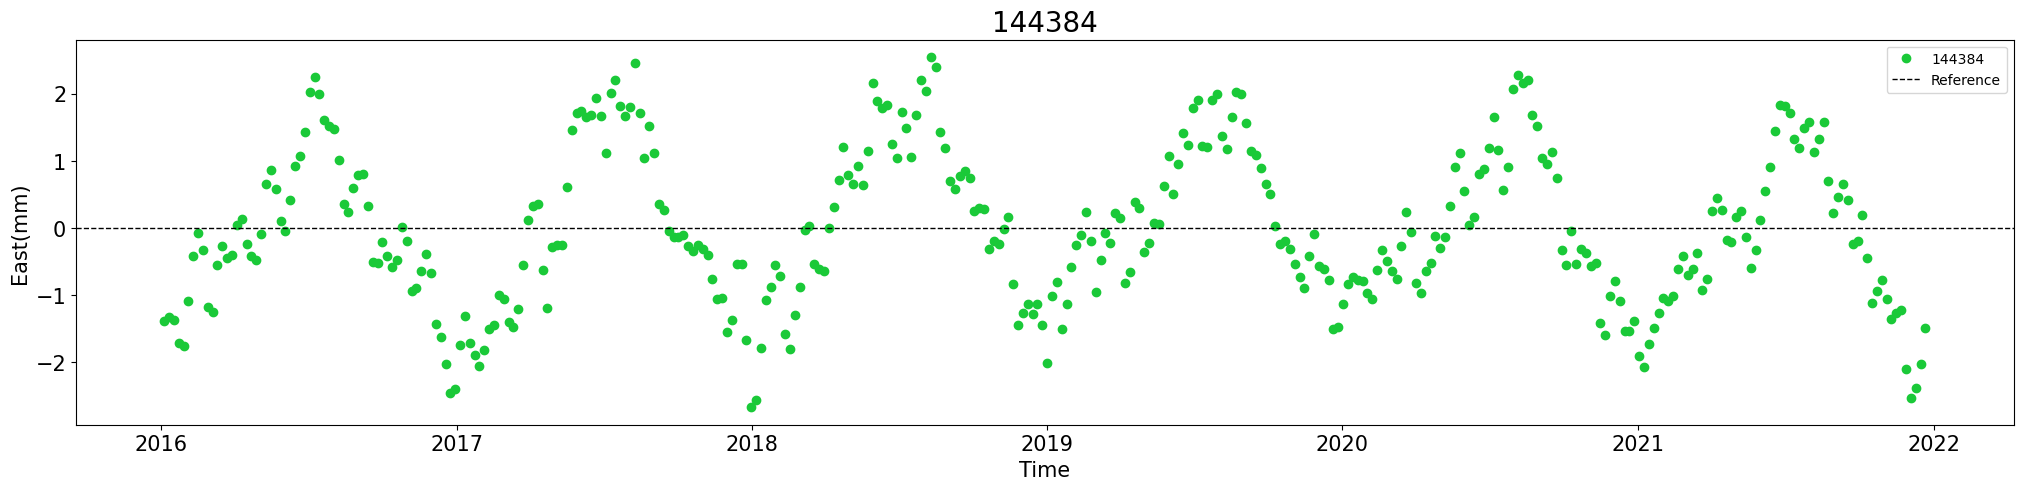

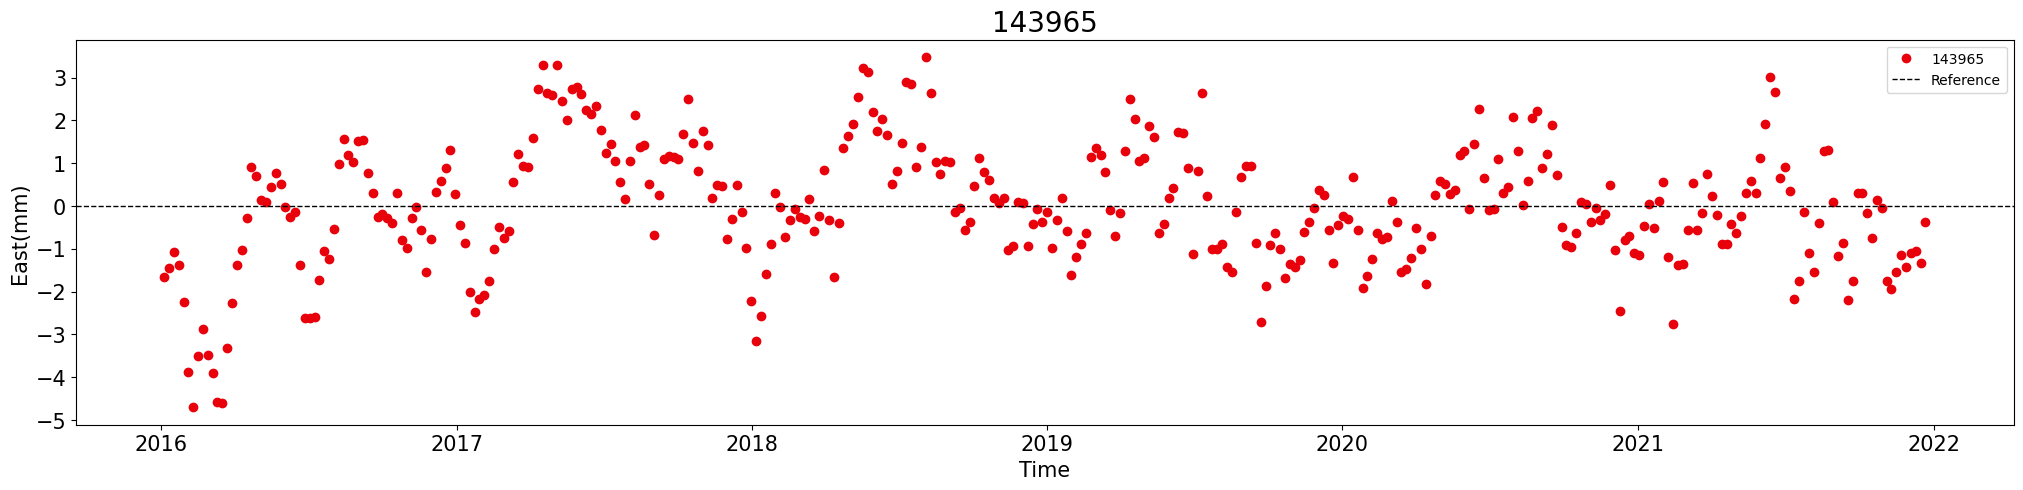

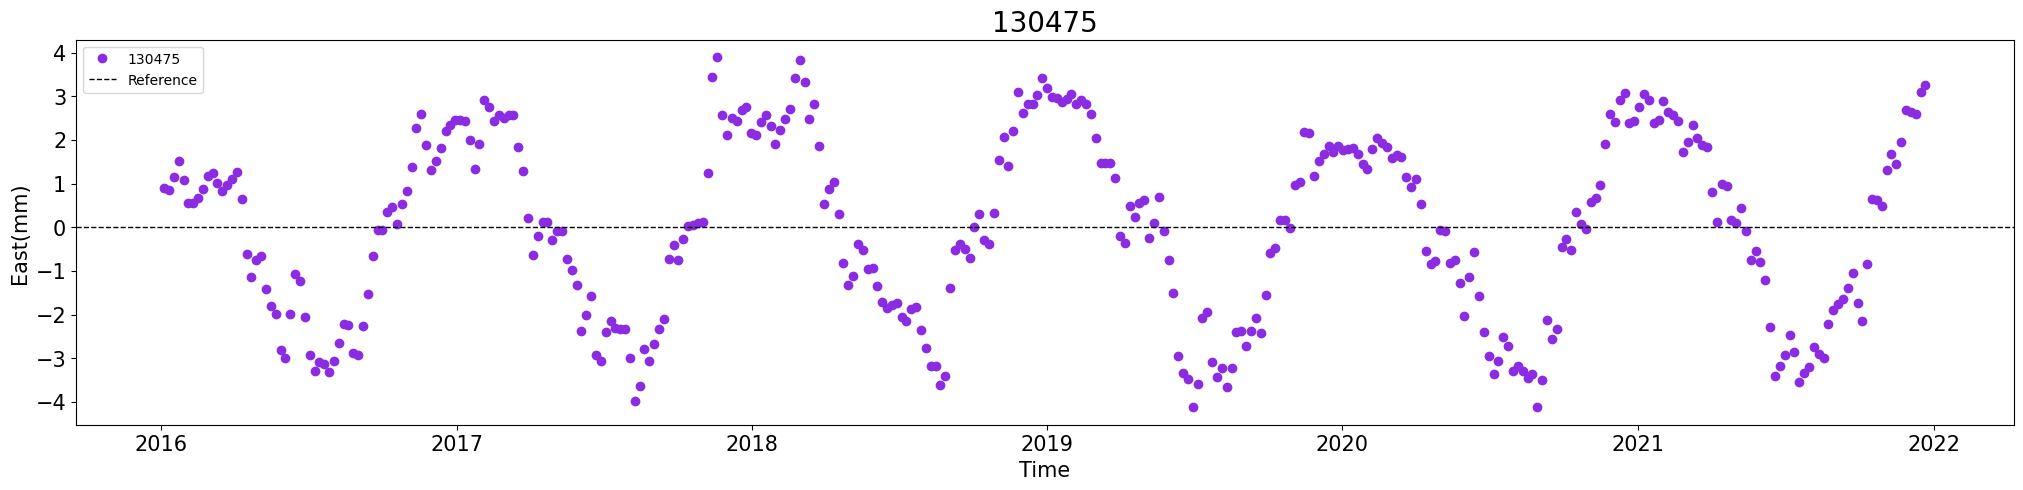

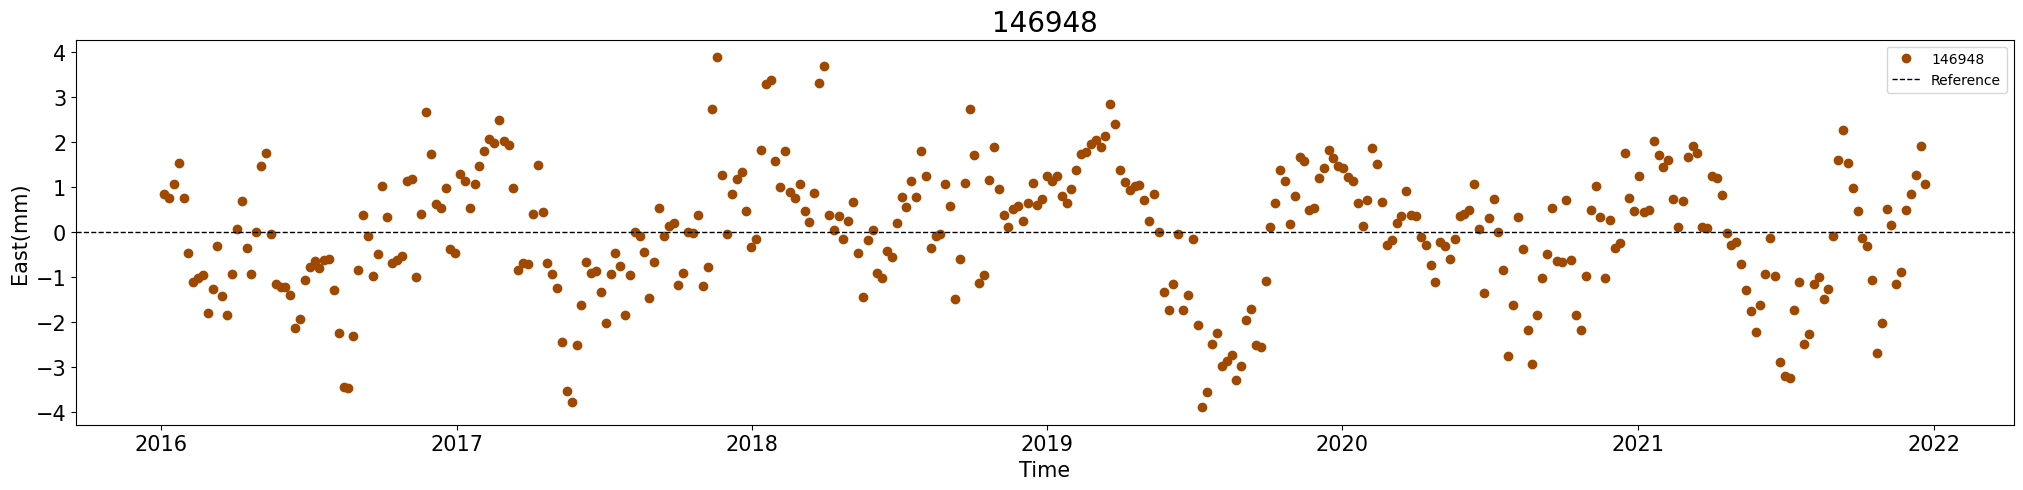

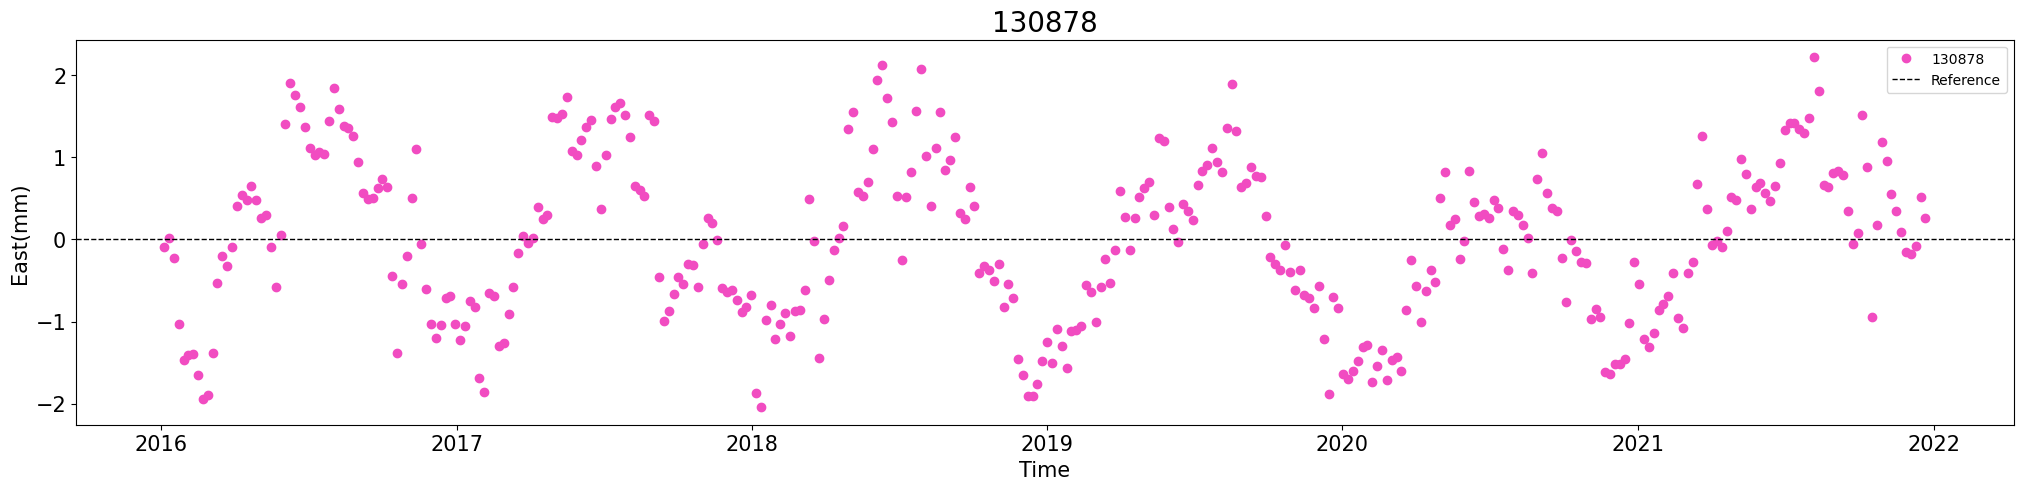

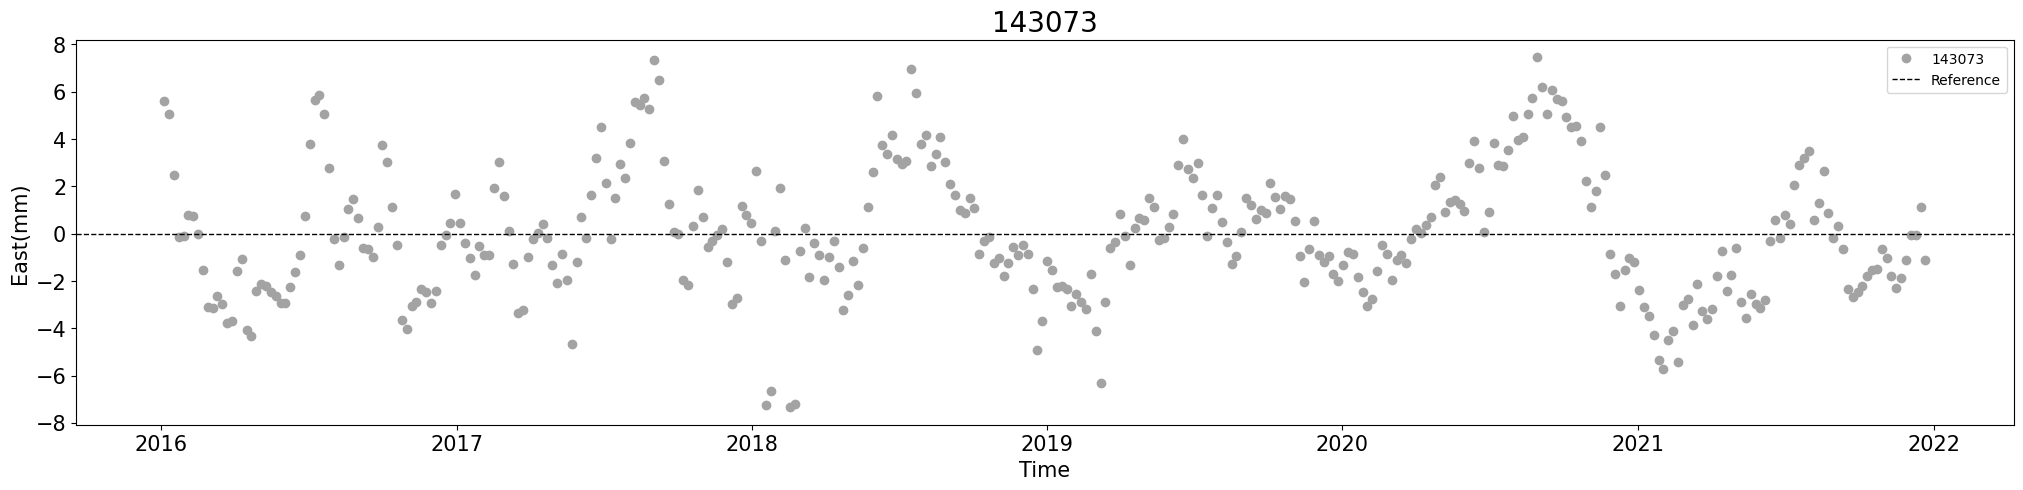

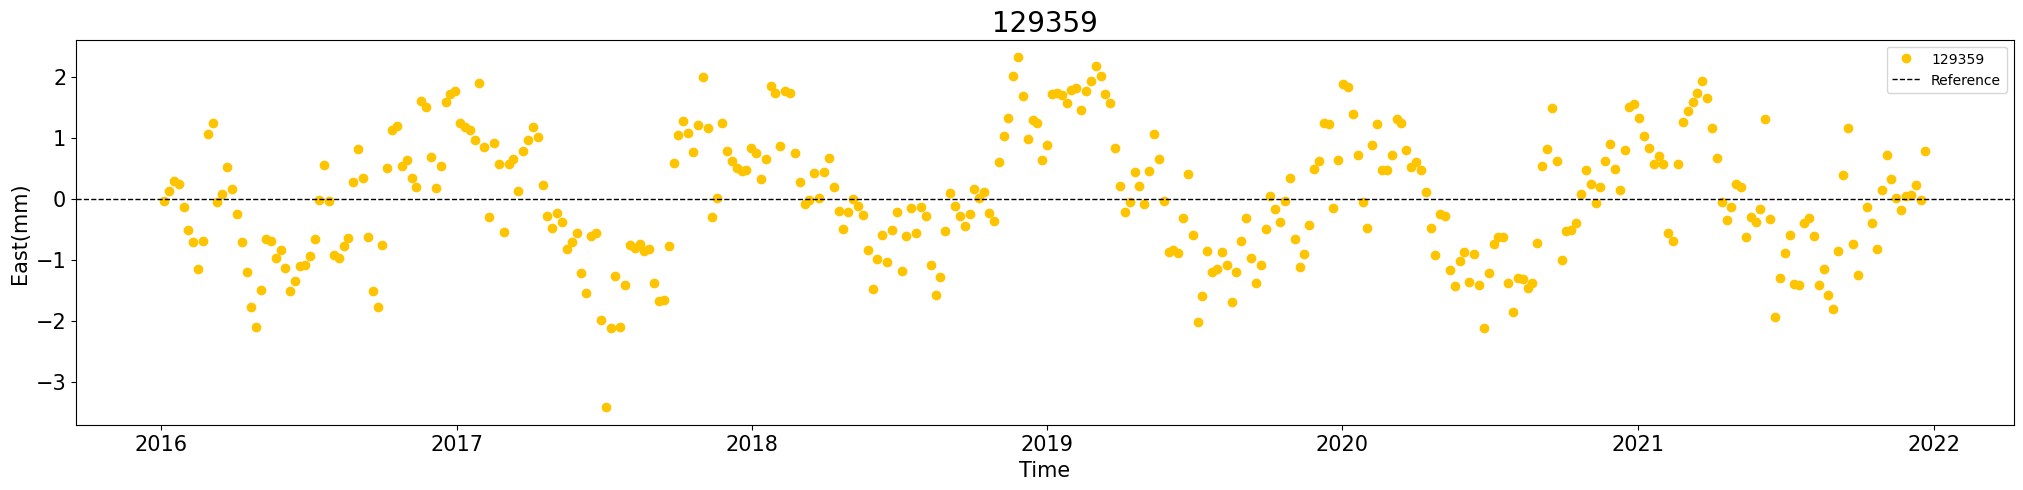

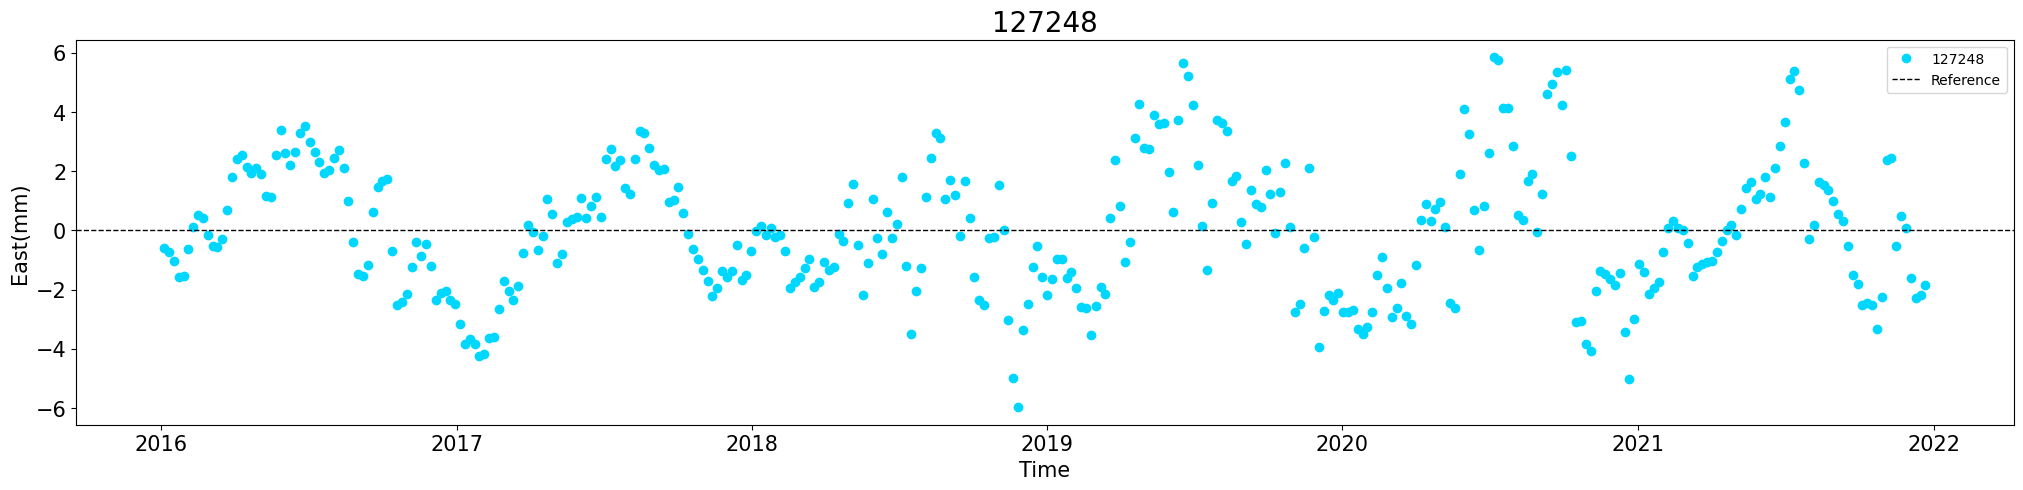

In [218]:
#checking the points plots - AFTER the reduction

colors = sns.color_palette("bright", len(points_avgrm_reduced))
folder = f'/home/rafaela/internship/time_series/TimeSeries-insar/egm_files/insar_ts_plots/east/points_after_avg_rolling_mean/{file_name}/graphics'

for i, (column, color) in enumerate(zip(points_avgrm_reduced.columns, colors)):
    plt.figure(figsize=(25, 5))
    plt.plot(points_avgrm_reduced.index, points_avgrm_reduced[column], 'o', color=color, lw=2, label=column) 
    
    plt.title(f'{column}', fontsize = 20)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Reference')
    plt.xlabel('Time', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.ylabel('East(mm)', fontsize = 15)                                       
    plt.yticks(fontsize=15)
    #plt.ylim(-0.008,0.008)
    #plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2018-07-15'))

    plt.legend()
    
    fl = os.path.join(folder, f'{column}.svg')
    f = io.BytesIO()
    #plt.savefig(fl, format="svg")
    
    plt.show()

In [317]:
def create_station_file (
    points_avgrm_reduced,
    index_selected, 
    station_name,
    folder_path):
    
    station_file = points_avgrm_reduced[index_selected].squeeze()
    station_file_df = pd.DataFrame(station_file)
    station_file_df.columns = [index_selected]
    
    return station_file_df

station_file_dict = {}
indexes_selected = []

if not indexes_selected:
    indexes_selected = list(points_avgrm_reduced.keys())

for index_selected, station_name, in zip(indexes_selected, [file_name]*len(indexes_selected)):
    
    station_file_df = create_station_file(points_avgrm_reduced,
                                          index_selected, 
                                          station_name,
                                          folder_path)
    
    station_file_dict[index_selected] = station_file_df

In [318]:
folder_path = f'/home/rafaela/internship/time_series/TimeSeries-insar/egm_files/insar_ts_plots/east/points_after_avg_rolling_mean/{file_name}'

concatenated_df = pd.concat(station_file_dict.values(), axis=1)
#file_path = os.path.join(folder_path, f'{file_name}_east_new.csv')
file_path = os.path.join(folder_path, f'{file_name}_distributed_pixels_avg_removed.csv')
concatenated_df.to_csv(file_path, index=True)

In [319]:
avg_points_selec = pd.DataFrame()

for indice_number, indice_data in station_file_dict.items():
    avg_points_selec[indice_number] = indice_data.squeeze()

avg2_station = avg_points_selec.mean(axis=1).rolling(2, min_periods=1).mean()
avg2_station_df = pd.DataFrame(avg2_station)
avg2_station_df.columns = ['avg2_east(mm)']

print(avg2_station_df)

            avg2_east(mm)
Date                     
2016-01-05  -1.009294e-17
2016-01-11   2.152713e-03
2016-01-17  -6.610044e-03
2016-01-23  -6.269597e-02
2016-01-29  -8.343460e-02
...                   ...
2021-11-28   2.451994e-02
2021-12-04  -7.641496e-04
2021-12-10  -1.487755e-01
2021-12-16  -1.053787e-01
2021-12-22   1.973902e-01

[364 rows x 1 columns]


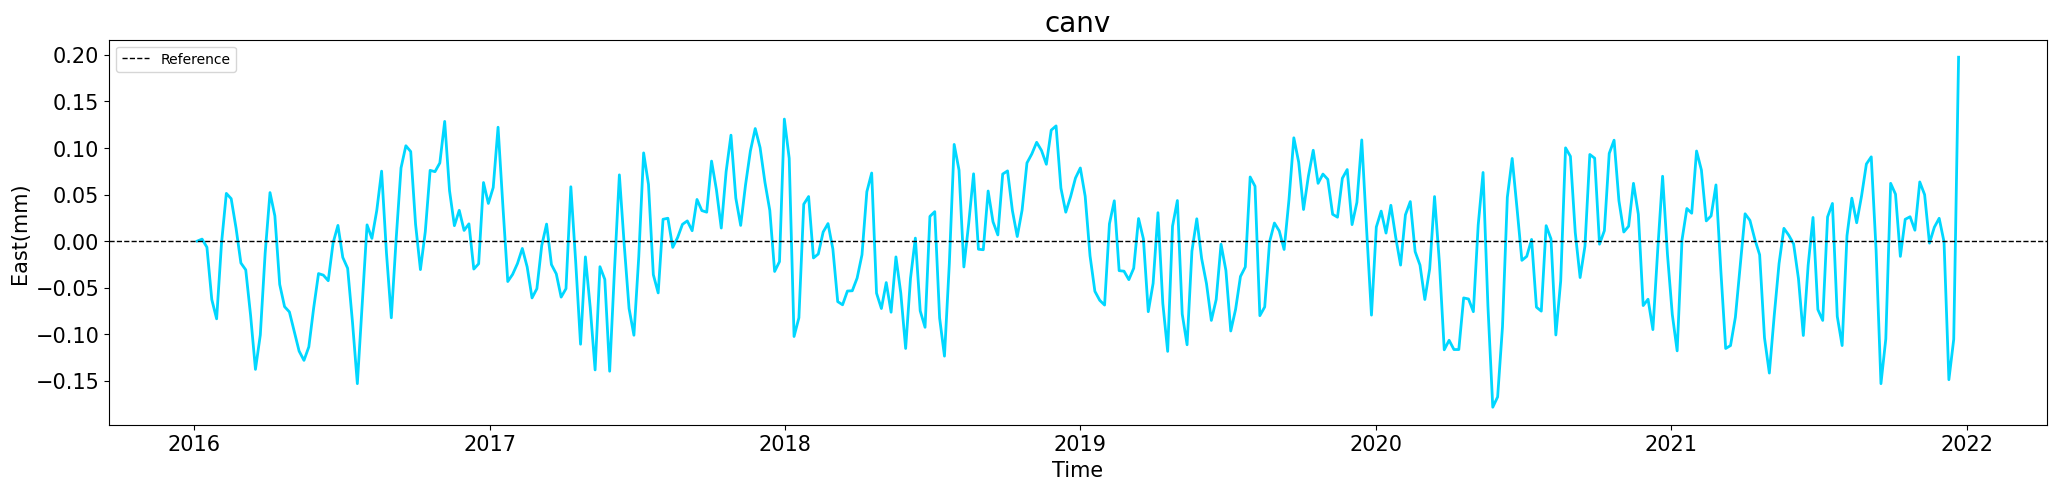

In [320]:
folder = f'/home/rafaela/internship/time_series/TimeSeries-insar/egm_files/insar_ts_plots/east/points_after_avg_rolling_mean/{station_name}'

plt.figure(figsize=(25, 5))

plt.plot(avg2_station_df.index, avg2_station_df, color=color, lw=2) 
plt.title(f'{file_name}', fontsize = 20)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Reference')
plt.xlabel('Time', fontsize = 15)
plt.xticks(fontsize=15)
plt.ylabel('East(mm)', fontsize = 15)                                       
plt.yticks(fontsize=15)
#plt.ylim(-0.008,0.008)

plt.legend()
    
fl = os.path.join(folder, f'AVG2 - {file_name}.svg')
f = io.BytesIO()
#plt.savefig(fl, format="svg")
    
plt.show()